<!-- https://moonbooks.org/Articles/How-to-create-a-table-of-contents-in-a-jupyter-notebook-/ -->

### Table of Contents

* [All Imports](#C1)
* [Import audio files and diarize them](#C1_1)
* [Chop audio files into multiple chunks](#C2)
* [Speech data processing and visualization](#C3)
    * [Transcribe Speech to text](#C3_1)
    * [Text and transcript pre-processing](#C3_2)
    * [Dataset generation for one session](#C3_3)
    * [Manual Dutch stopword removal](#C3_4)
    * [Word processing and feature creation](#C3_5)
    * [Plot group members' word frequency](#C3_6)
    * [Topic modeling using LDA](#C3_7)
    * [Topic modeling using LSA](#C3_8)
    * [Generate the knowledge graph](#C3_9)
    * [Calculate the turn-taking between group members](#C3_10)
    * [Generate bigrams, trigrams, co-occurence matrix of the group conversations](#C3_11)
    * [Stylized knowledge graph](#C3_12)
    * [Interactive network graph with networkx and pyvis](#C3_13)
    * [Network graph showing multiple group member roles](#C3_14)
    * [Network graph with different centrality measures](#C3_15)

# All Imports <a class="anchor" id="C1"></a>

In [1]:
%load_ext autoreload
%autoreload 2
%aimport testmultiprocess
%reload_ext autoreload

## Here Python 3 is used and assumption is that all these packages have been installed
## We recommend using this Jupyter Notebook in a 

import speech_recognition as sr
import sounddevice as sd
import numpy as np
from numpy import linalg as LA
import time
import multiprocessing as mp
from multiprocessing import Process, Value, Array
import subprocess
import os
import stat
import datetime
from os import path
from PIL import Image
#import testmultiprocess
import speechtotext #Multiprocessing speech to text example in a file
import Record_audio_speakingabovethreshold
import pandas as pd
from pandasgui import show
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import nltk
import re
import librosa
import pyaudio
import wave
from pydub import AudioSegment,silence
from collections import Counter
from collections import defaultdict
from itertools import islice, zip_longest
import networkx as nx
import csv
import lda2vec
#import pyldavis and enable in Jupyter notebook
import pyLDAvis
import pyLDAvis.gensim

# more common imports
import pandas as pd
import numpy as np
from collections import Counter
import re
#Load this to calculate ngrams from a list sequence
from itertools import tee, islice

# languange processing imports
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk import word_tokenize,sent_tokenize
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set()  # defines the style of the plots to be seaborn style

#import matplotlib.pyplot as plt
#% matplotlib inline

C:\Users\sambi\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning:

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.



# Import audio files in one session and do speaker diarization using voxsort <a class="anchor" id="C1_1"></a>

In [30]:
df = pd.read_csv("./MarcelSessionDutch1/Docent_60minutes.csv", sep=";")
#df1 = pd.read_csv("./MarcelSessionDutch1/Docent_60minutes.csv", sep=";")
print(df)
#print(df1)

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html

#df3 = pd.concat([df, df1], ignore_index=True)
#print(df3)
#print(df3.loc[[626]])



     Number  Start time in milliseconds  End time in milliseconds  Text
0         1                           0                       639    2:
1         2                         640                      2319    1:
2         3                        2320                      2639    2:
3         4                        2640                      8239  256:
4         5                        8240                      8319    2:
..      ...                         ...                       ...   ...
710     711                     1792240                   1792319    2:
711     712                     1792320                   1795999  256:
712     713                     1796000                   1796079    2:
713     714                     1796080                   1799759  256:
714     715                     1799760                   1799919   NaN

[715 rows x 4 columns]


In [39]:
#https://www.kite.com/python/answers/how-to-read-columns-from-a-csv-file-to-lists-in-python
# Export the timestamps from the csv file to a list
#column_names = ["Number", "Start time in milliseconds", "End time in milliseconds", "Text"]
df = pd.read_csv("./MarcelSessionDutch1/Docent_30minutes.csv", sep=";")

#Modify the files naming and author or group member names
df['Names'] = df['Text'].shift(1)
df.Names=df.Names.str.replace(':','')

print(df)

#list_of_timestamps = df['End time in milliseconds'].to_list()
#print(list_of_timestamps)
#print(type(list_of_timestamps[0]))

     Number  Start time in milliseconds  End time in milliseconds  Text Names
0         1                           0                      1759  256:   NaN
1         2                        1760                      1919  256:   256
2         3                        1919                      2079    1:   256
3         4                        2080                     23599  256:     1
4         5                       23600                     23679    1:   256
..      ...                         ...                       ...   ...   ...
621     622                     1790880                   1790959    5:   256
622     623                     1790960                   1795359    4:     5
623     624                     1795360                   1796639    3:     4
624     625                     1796640                   1799839  256:     3
625     626                     1799840                   1799999   NaN   256

[626 rows x 5 columns]


# Chop audio files into multiple chunks based on timestamps after speaker diarization <a class="anchor" id="C2"></a>

In [12]:
#https://stackoverflow.com/questions/51622865/break-up-a-wav-file-by-timestamp

audio_file= "./MarcelSessionDutch1/audio_chunk_5419000_studycoach.wav"
audio = AudioSegment.from_wav(audio_file)
list_of_timestamps = df['End time in milliseconds'].to_list() #For dividing each 30 minutes chunk
# list_of_timestamps = [1799999, 3599999, 5399999] #For the original file
#list_of_timestamps = [3599999, 5399999]

start = 0
#start = 1800000 #Change this to 30 minutes in milli seconds when starting from the next 30 minute chunk
for  idx,t in enumerate(list_of_timestamps):
    #break loop if at last element of list
    if idx == len(list_of_timestamps):
        break

    end = t #pydub works in millisec
    print ("split at [ {}:{}] ms".format(start, end))
    audio_chunk=audio[start:end]
    #The timestamps are attached to the end of the file name
    audio_chunk.export( "./MarcelSessionDutch1/AudioChunks90/audio_chunk_{}.wav".format(end), format="wav")

    start = end #pydub works in millisec

split at [ 0:639] ms
split at [ 639:2159] ms
split at [ 2159:9599] ms
split at [ 9599:10959] ms
split at [ 10959:13599] ms
split at [ 13599:13759] ms
split at [ 13759:18799] ms
split at [ 18799:18879] ms
split at [ 18879:24559] ms
split at [ 24559:26959] ms
split at [ 26959:28239] ms
split at [ 28239:29679] ms
split at [ 29679:31359] ms
split at [ 31359:32239] ms
split at [ 32239:32279] ms
split at [ 32279:32319] ms
split at [ 32319:34879] ms
split at [ 34879:35279] ms
split at [ 35279:36719] ms
split at [ 36719:38639] ms
split at [ 38639:44079] ms
split at [ 44079:44279] ms
split at [ 44279:44479] ms
split at [ 44479:46239] ms
split at [ 46239:47039] ms
split at [ 47039:47119] ms
split at [ 47119:48959] ms
split at [ 48959:49759] ms
split at [ 49759:49839] ms
split at [ 49839:49919] ms
split at [ 49919:53839] ms
split at [ 53839:53919] ms
split at [ 53919:64959] ms
split at [ 64959:65199] ms
split at [ 65199:65279] ms
split at [ 65279:75679] ms
split at [ 75679:75839] ms
split at [ 75

# Speech data processing and visualization <a class="anchor" id="C3"></a>

## Run Google Speech to Text for free! <a class="anchor" id="C3_1"></a>

In [13]:
#Run Dutch Google speech to Text

## https://www.geeksforgeeks.org/audio-processing-using-pydub-and-google-speechrecognition-api/
## Can only change the overlap duration and the interval of each chunk
# Import necessary libraries 
#from pydub import AudioSegment 
#import speech_recognition as sr 
#import os

device_files_global = []
device_index = []
## 4 appends to create 4 lists with one for each of the audio device
#device_files_global.append([])
#device_files_global.append([])
#device_files_global.append([])
#device_files_global.append([])
#device_index = [1,2,3,4]

nr_device = 1 #Number of audio devices # CHANGE THIS!!??

for i in range(nr_device):
    device_files_global.append([])
    device_index.append(i+1)

for i in device_index:
    ## Set the base and current directory path
    basepath = r'C:\Users\sambi\Downloads\SpeechToText'
    currentpath = os.path.join(basepath, 'MarcelSessionDutch1\AudioChunks90')

    #device_files_local[i-1] = []
    # List all files in a directory using os.listdir except the text files and only read the wave files
    for entry in os.listdir(currentpath):
        if os.path.isfile(os.path.join(currentpath, entry)):
            if entry.endswith('.txt') != True:
                device_files_global[i-1].append(entry) if entry not in device_files_global[i-1] else device_files_global[i-1].remove(entry)
    #print(files)
    #device_files_local[i-1].append(entry) if entry not in device_files_global[i-1] else device_files_local[i-1]

    # Input audio file to be sliced 
    #### Replace all forward slashes (\) with backward slashes (/) in the file path for the windows machine!

    for sound_file in device_files_global[i-1]:

        fileread_path = os.path.join(currentpath, sound_file)
        #audio = AudioSegment.from_wav("C:/Users/sambi/Downloads/SpeechToText/device1/4.wav") 
        audio = AudioSegment.from_wav(fileread_path)

        #''' 
        #Step #1 - Slicing the audio file into smaller chunks. 
        #'''
        # Length of the audiofile in milliseconds 
        n = len(audio) 

        # Variable to count the number of sliced chunks 
        counter = 1

        # NAMING of the Text file to write the recognized audio 
        filewrite_path = os.path.join(currentpath, '%s.txt' % sound_file.split(".")[0])
        #print("Before used%s", i)
        #filewrite_path = os.path.join(currentpath, 'dev%s.txt' % i)
        #print("After used%s", i)
        #fh = open("C:/Users/sambi/Downloads/SpeechToText/device1/device1.txt", "w+") 
        fh = open(filewrite_path, "w+") 

        # Interval length at which to slice the audio file. 
        # If length is 22 seconds, and interval is 5 seconds, 
        # The chunks created will be: 
        # chunk1 : 0 - 5 seconds 
        # chunk2 : 5 - 10 seconds 
        # chunk3 : 10 - 15 seconds 
        # chunk4 : 15 - 20 seconds 
        # chunk5 : 20 - 22 seconds 
        interval = 10 * 1000 #10 second chunk length works the best for now with Maren's and Sambit's audio files!!

        # Length of audio to overlap.  
        # If length is 22 seconds, and interval is 5 seconds, 
        # With overlap as 1.5 seconds, 
        # The chunks created will be: 
        # chunk1 : 0 - 5 seconds 
        # chunk2 : 3.5 - 8.5 seconds 
        # chunk3 : 7 - 12 seconds 
        # chunk4 : 10.5 - 15.5 seconds 
        # chunk5 : 14 - 19.5 seconds 
        # chunk6 : 18 - 22 seconds 
        overlap = 1.5 * 1000

        # Initialize start and end seconds to 0 
        start = 0
        end = 0

        # Flag to keep track of end of file. 
        # When audio reaches its end, flag is set to 1 and we break 
        flag = 0

        # Iterate from 0 to end of the file, 
        # with increment = interval 
        for j in range(0, 2 * n, interval): 

            # During first iteration, 
            # start is 0, end is the interval 
            if j == 0: 
                start = 0
                end = interval 

            # All other iterations, 
            # start is the previous end - overlap 
            # end becomes end + interval 
            else: 
                start = end - overlap 
                end = start + interval  

            # When end becomes greater than the file length, 
            # end is set to the file length 
            # flag is set to 1 to indicate break. 
            if end >= n: 
                end = n 
                flag = 1

            # Storing audio file from the defined start to end 
            chunk = audio[start:end] 

            # Filename / Path to store the sliced audio 
            filename = 'chunk'+str(counter)+'.wav'

            # Store the sliced audio file to the defined path 
            chunk.export(filename, format ="wav") 
            # Print information about the current chunk 
            print("Processing chunk "+str(counter)+". Start = "
                                +str(start)+" end = "+str(end)) 

            # Increment counter for the next chunk 
            counter = counter + 1

            # Slicing of the audio file is done. 
            # Skip the below steps if there is some other usage 
            # for the sliced audio files. 


        #''' 
        #Step #2 - Recognizing the chunk and writing to a file. 
        #'''

            # Here, Google Speech Recognition is used 
            # to take each chunk and recognize the text in it. 

            # Specify the audio file to recognize 

            AUDIO_FILE = filename 

            # Initialize the recognizer 
            r = sr.Recognizer() 

            # Traverse the audio file and listen to the audio 
            with sr.AudioFile(AUDIO_FILE) as source: 
                #r.adjust_for_ambient_noise(source)
                audio_listened = r.listen(source) 

            # Try to recognize the listened audio 
            # And catch expections. 
            try:     
                rec = r.recognize_google(audio_listened, language="nl-NL") #"de-DE" for German

                # If recognized, write into the file. 
                fh.write(rec+" ") 

            # If google could not understand the audio 
            except sr.UnknownValueError: 
                print("Could not understand audio") 

            # If the results cannot be requested from Google. 
            # Probably an internet connection error. 
            except sr.RequestError as e: 
                print("Could not request results.") 

            # Check for flag. 
            # If flag is 1, end of the whole audio reached. 
            # Close the file and break. 
            if flag == 1: 
                fh.close() 
                break


#Merge the speech to text with the original person name file which is nothing but
#BUILDING the NEW dataframe for first 30 minutes



#Then proceed with the Dutch NLTK



#Then the analysis



#Then the visualization

<>:28: DeprecationWarning:

invalid escape sequence \A

<>:28: DeprecationWarning:

invalid escape sequence \A

<>:28: DeprecationWarning:

invalid escape sequence \A

<ipython-input-13-58c9280e332d>:28: DeprecationWarning:

invalid escape sequence \A



Processing chunk 1. Start = 0 end = 3760
Processing chunk 1. Start = 0 end = 80
Could not understand audio
Processing chunk 1. Start = 0 end = 4080
Processing chunk 1. Start = 0 end = 8800
Processing chunk 1. Start = 0 end = 80
Could not understand audio
Processing chunk 1. Start = 0 end = 800
Could not understand audio
Processing chunk 1. Start = 0 end = 80
Could not understand audio
Processing chunk 1. Start = 0 end = 4720
Processing chunk 1. Start = 0 end = 80
Could not understand audio
Processing chunk 1. Start = 0 end = 2320
Processing chunk 1. Start = 0 end = 6320
Processing chunk 1. Start = 0 end = 80
Could not understand audio
Processing chunk 1. Start = 0 end = 160
Could not understand audio
Processing chunk 1. Start = 0 end = 80
Could not understand audio
Processing chunk 1. Start = 0 end = 2080
Processing chunk 1. Start = 0 end = 800
Could not understand audio
Processing chunk 1. Start = 0 end = 2880
Processing chunk 1. Start = 0 end = 80
Could not understand audio
Processin

## Text and transcript pre-processing <a class="anchor" id="C3_2"></a>

In [40]:
## To convert a list to a string
def listToString(s):  
    
    # initialize an empty string 
    str1 = ""  
    
    # traverse in the string   
    for ele in s:  
        str1 += ele   
    
    # return string   
    return str1  
## Writing and operation on the CSV files
## https://www.programiz.com/python-programming/writing-csv-files
# Creates an empty list to store the info about each device in a sublist
#https://www.datacamp.com/community/tutorials/python-list-comprehension

device_files_global = []
device_index = []
row_list = [["End time in milliseconds", "Text"]]

nr_device = 1 #Number of audio devices

#Creates the list to store the number of audio devices and the sublists for the global device info list
for i in range(nr_device):
    device_files_global.append([])
    device_index.append(i+1)
for i in device_index:
    ## Set the base and current directory path
    basepath = r'C:\Users\sambi\Downloads\SpeechToText'
    currentpath = os.path.join(basepath, 'MarcelSessionDutch1\AudioChunks')

    #device_files_local[i-1] = []
    # List all files in a directory using os.listdir except the text files and only read the wave files
    
    for entry in os.listdir(currentpath):
        if os.path.isfile(os.path.join(currentpath, entry)):
            #if entry.endswith('.txt') == True:
             #   device_text_files[i-1].append(entry) if entry not in device_text_files[i-1] else device_text_files[i-1].remove(entry)
            if entry.endswith('.txt') == True:
                device_files_global[i-1].append(entry) if entry not in device_files_global[i-1] else device_files_global[i-1].remove(entry)
    
    for sound_file in device_files_global[i-1]:
        fileread_path = os.path.join(currentpath, sound_file)
        #os.path.splitext(sound_file)[0] for a string and not a list like in split
        #textfile_path = os.path.join(currentpath, listToString(sound_file.split('.')[0]) + ".txt")
        textfile_content = open(fileread_path, "r")
        
        row_list.append([sound_file.split('_')[-1].split('.')[0], textfile_content.read()])
print(row_list)

<>:31: DeprecationWarning:

invalid escape sequence \A

<>:31: DeprecationWarning:

invalid escape sequence \A

<>:31: DeprecationWarning:

invalid escape sequence \A

<ipython-input-40-7a5780fc3bee>:31: DeprecationWarning:

invalid escape sequence \A



[['End time in milliseconds', 'Text'], ['1001119', 'ja '], ['1004959', 'een boek gelezen hebben weer.nl lopen '], ['1006319', ''], ['1006399', ''], ['1006639', ''], ['1006879', ''], ['1013279', 'beginnen dan met met de beugel Uitslag testvragen uitslag test ofzo '], ['1014479', 'ja '], ['1019839', 'beginnen met voorkennis activeren dood vragen van '], ['1019919', ''], ['1020239', ''], ['1020319', ''], ['1022239', 'nu nodig '], ['1022319', ''], ['1024079', '6 '], ['1024159', ''], ['1026639', 'hebben ze hebben we allemaal hetzelfde startpunt '], ['1026719', ''], ['1033759', 'allemaal met dezelfde kennis '], ['1033839', ''], ['1033919', ''], ['1039359', 'dat dat klopt dat dat dat niet gedaan heb '], ['1041279', 'dan gaan we nu '], ['1049759', '6 '], ['1049839', ''], ['1049919', ''], ['1051439', ''], ['1051519', ''], ['1054159', ''], ['1058399', 'Wat betekent voorspel '], ['1061279', 'kan je dan een '], ['1062399', ''], ['1066959', 'dat antwoord komt op het kaartje Wat moet doen '], ['1068

In [41]:
#sound_file = 'audio_chunk_1759.txt'
#print(sound_file.split('_')[-1].split('.')[0])
df_text = pd.DataFrame(row_list[1:],columns=row_list[0])
df_text["End time in milliseconds"] = pd.to_numeric(df_text["End time in milliseconds"])
df_text_sort = df_text.sort_values('End time in milliseconds')
print(df_text_sort)
#print(df_text.dtypes)
#print(df_text_sort.head(n=3))

     End time in milliseconds  \
301                      1759   
319                      1919   
332                      2079   
342                     23599   
343                     23679   
..                        ...   
311                   1790959   
312                   1795359   
313                   1796639   
314                   1799839   
315                   1799999   

                                                  Text  
301                                                     
319                                                     
332                                                     
342  Nou de voorbereidingen gedaan dan Ja zijn alle...  
343                                                     
..                                                 ...  
311                                                     
312                                                     
313                                                     
314                              

In [42]:
#MERGE RULES
#https://stackoverflow.com/questions/43297589/merge-two-data-frames-based-on-common-column-values-in-pandas
df_text_name = df.merge(df_text_sort, on='End time in milliseconds', how = 'inner')
print(df_text_name) # All the attributes are present in this dataframe

     Number  Start time in milliseconds  End time in milliseconds Text_x  \
0         1                           0                      1759   256:   
1         2                        1760                      1919   256:   
2         3                        1919                      2079     1:   
3         4                        2080                     23599   256:   
4         5                       23600                     23679     1:   
..      ...                         ...                       ...    ...   
621     622                     1790880                   1790959     5:   
622     623                     1790960                   1795359     4:   
623     624                     1795360                   1796639     3:   
624     625                     1796640                   1799839   256:   
625     626                     1799840                   1799999    NaN   

    Names                                             Text_y  
0     NaN               

In [43]:
#Add timestamps to the succeeding 60 and 90 minutes chunk
#Change this for 30 to 60 minutes and 60 to 90 minutes chunk

#df_text_name['Start time in milliseconds'] = df_text_name['Start time in milliseconds'].apply(lambda x: x + 1800000)
#df_text_name['End time in milliseconds'] = df_text_name['End time in milliseconds'].apply(lambda x: x + 1800000)
df_text_name = df_text_name.drop(['Text_x','Number'], axis=1)

#Change this for every chunk
#Roles: Game Master, Teacher, TELI LA Advisor, Study Coach, Educational Advisor, Student

df_text_name['Names'] = df_text_name['Names'].replace({'1': 'Game Master', '2': 'Teacher', '3': 'TELI LA Advisor', '4': 'Study Coach', '5': 'Educational Advisor', '6': 'Student'})
print(df_text_name)

     Start time in milliseconds  End time in milliseconds  \
0                             0                      1759   
1                          1760                      1919   
2                          1919                      2079   
3                          2080                     23599   
4                         23600                     23679   
..                          ...                       ...   
621                     1790880                   1790959   
622                     1790960                   1795359   
623                     1795360                   1796639   
624                     1796640                   1799839   
625                     1799840                   1799999   

                   Names                                             Text_y  
0                    NaN                                                     
1                    256                                                     
2                    256         

In [44]:
df_text_name.to_csv(r'.\MarcelSessionDutch1\0to30.csv')

## Generating the desired dataset for one session <a class="anchor" id="C3_3"></a>

In [49]:
df = pd.read_csv("./MarcelSessionDutch1/0to30.csv")
df1 = pd.read_csv("./MarcelSessionDutch1/30to60.csv")
df2 = pd.read_csv("./MarcelSessionDutch1/60to90.csv")
print(df)
print(df1)
print(df2)

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html

df3 = pd.concat([df, df1, df2], ignore_index=True)
print(df3)
df3 = df3.loc[:, ~df.columns.str.contains('^Unnamed')]
print(df3)

#print(df3.loc[[626]])
df3.to_csv(r'.\MarcelSessionDutch1\Session1_12thOct2020.csv')

     Unnamed: 0  Start time in milliseconds  End time in milliseconds  \
0             0                           0                      1759   
1             1                        1760                      1919   
2             2                        1919                      2079   
3             3                        2080                     23599   
4             4                       23600                     23679   
..          ...                         ...                       ...   
621         621                     1790880                   1790959   
622         622                     1790960                   1795359   
623         623                     1795360                   1796639   
624         624                     1796640                   1799839   
625         625                     1799840                   1799999   

                   Names                                             Text_y  
0                    NaN                     

In [2]:
#Extract the necessary columns from processed data 
df = pd.read_csv("./MarcelSessionDutch1/Session1_12thOct2020_Copy.csv")
df['Start time in milliseconds'] = pd.to_numeric(df['Start time in milliseconds'])

#Different phases during the game session
#df = df[(df['Start time in milliseconds'] < 680000)] #White Phase (Intro)
#df = df[(df['Start time in milliseconds'] > 680000) & (df['Start time in milliseconds'] < 2988000)] #Blue Phase
df = df[(df['Start time in milliseconds'] > 2988000) & (df['Start time in milliseconds'] < 3738520)] #Red Phase
#df = df[(df['Start time in milliseconds'] > 3738520)] #Yellow Phase

print(df)

train_data_raw = df[['Text_y','Names']]
#print(train_data_raw)
#Remove the null rows which don't have any text
train_data = train_data_raw.dropna()
train_data = train_data[train_data.Names != '256']
train_data = train_data[train_data.Names != '128']
train_data = train_data[train_data.Names != ' ']
train_data = train_data[train_data['Text_y'] != ""]
train_data.insert(0, 'id', range(0, 0 + len(train_data)))
train_data = train_data.rename(columns={"Number": "id", "Text_y":"text", "Names":"author"})

#Take care of the codings in red, yellow phase with both TELI LA Advisor and TEL LA Advisor
train_data['author'] = train_data['author'].replace({'Game Master': '1', 'Teacher': '2', 'TEL LA Advisor': '3', 'TELI LA Advisor': '3', 'Study Coach': '4', 'Educational Advisor': '5', 'Student': '6'})
print(train_data)


      Unnamed: 0  Start time in milliseconds  End time in milliseconds  \
1107        1107                     2988800                   2991439   
1108        1108                     2991440                   3009839   
1109        1109                     3009840                   3009919   
1110        1110                     3009920                   3012159   
1111        1111                     3012160                   3012239   
...          ...                         ...                       ...   
1399        1399                     3728680                   3731559   
1400        1400                     3731560                   3731639   
1401        1401                     3731640                   3736679   
1402        1402                     3736680                   3738439   
1403        1403                     3738440                   3738519   

               Names                                             Text_y  
1107         Teacher                 

In [3]:
#https://towardsdatascience.com/pandas-dataframe-group-by-consecutive-same-values-128913875dba
#Grouping multiple consecutive utterances of the same person or author

train_data_grouped_condition = train_data.groupby((train_data['author'].shift() != train_data['author']).cumsum())
train_data_grouped_final = pd.DataFrame({
    'id': train_data_grouped_condition['id'].min(),
    'text': train_data_grouped_condition['text'].apply(' '.join),
    'author': train_data_grouped_condition['author'].min()
})

#train_data_grouped_final.drop(train_data_grouped_final.columns[[0, 1]], axis = 1, inplace = True)
print(train_data_grouped_final)


train_data = train_data_grouped_final
print(train_data)

         id                                               text author
author                                                               
1         0                        Oké nou ja sluit even deze       2
2         1  tijds overwegingen volgende stap bestaat kijke...      1
3         4                                              Hans       4
4         5                                       onderstaand       5
5         6      Nou ja  je hoeft je niet te typen  onderkant       2
...     ...                                                ...    ...
77      110                          Ja dat doet de studenten       3
78      111                     dat het kunnen leveren Dat is       1
79      112  dat is moodle moet er ook daarvoor liggen denk...      3
80      113                           nee nee  specifiek  oké       1
81      116  maar je zou wel doen  maar goed PowerPoint ofz...      3

[81 rows x 3 columns]
         id                                               text auth

## Remove more common Dutch stop words manually! <a class="anchor" id="C3_4"></a>

In [4]:
#List of Dutch stop words: https://eikhart.com/blog/dutch-stopwords-list

with open('dutchstopwords.txt' , 'r') as f:
    stoplines = f.readlines()
converted_stoplines = []
for element in stoplines:
    converted_stoplines.append(element.strip())
print(converted_stoplines)

['a', 'aan', 'aangaande', 'aangezien', 'achter', 'achterna', 'aen', 'af', 'afd', 'afgelopen', 'agter', 'al', 'aldaar', 'aldus', 'alhoewel', 'alias', 'alle', 'allebei', 'alleen', 'alleenlyk', 'allen', 'alles', 'als', 'alsnog', 'altijd', 'altoos', 'altyd', 'ander', 'andere', 'anderen', 'anders', 'anderszins', 'anm', 'b', 'behalve', 'behoudens', 'beide', 'beiden', 'ben', 'beneden', 'bent', 'bepaald', 'beter', 'betere', 'betreffende', 'bij', 'bijna', 'bijvoorbeeld', 'bijv', 'binnen', 'binnenin', 'bizonder', 'bizondere', 'bl', 'blz', 'boven', 'bovenal', 'bovendien', 'bovengenoemd', 'bovenstaand', 'bovenvermeld', 'buiten', 'by', 'daar', 'daarheen', 'daarin', 'daarna', 'daarnet', 'daarom', 'daarop', 'daarvanlangs', 'daer', 'dan', 'dat', 'de', 'deeze', 'den', 'der', 'ders', 'derzelver', 'des', 'deszelfs', 'deszelvs', 'deze', 'dezelfde', 'dezelve', 'dezelven', 'dezen', 'dezer', 'dezulke', 'die', 'dien', 'dikwijls', 'dikwyls', 'dit', 'dl', 'doch', 'doen', 'doet', 'dog', 'door', 'doorgaand', 'doo

## Word pre-processing and feature creation <a class="anchor" id="C3_5"></a>

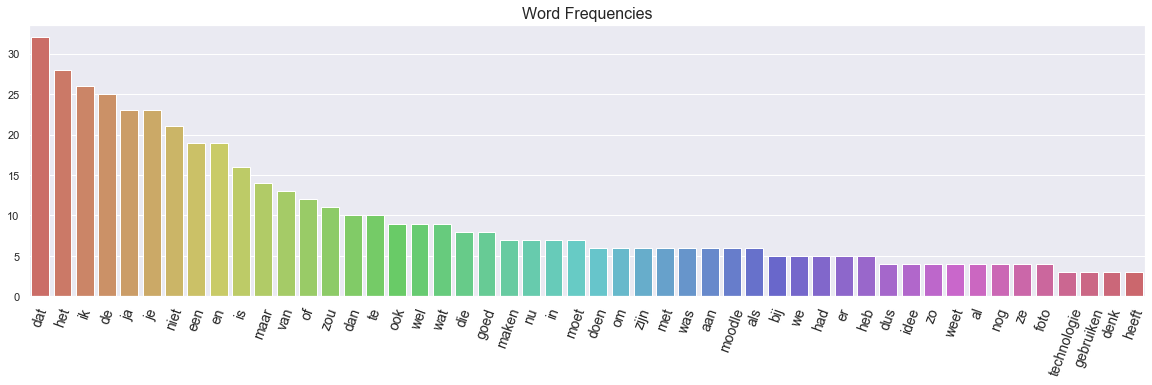

In [5]:
#Feature creation: The usual approach in natural language processing, is to first kind of cleanse the text. 
#We have to make sure our model can understand similarities and understand when two different words mean similar things. 
#You can't just input the raw text into a model and expect it to understand everything. 
#Therefore, the following are the most common steps to take in order to achieve this cleansing.

#Tokenize the text; split sentences in (good) words. Thus watch out for punctuation.
#Remove words that mean little; these are usually words that occur very frequently or words that occur very infrequently. Also, punctuation can be removed, but perhaps you'd like to keep some punctuation in, like exclamation marks or question marks since maybe one writer uses them more than others.
#Stemming; this basically means joining words that mean the same. Take for example the words running and runs, the stem of both words is run. Thus with stemming you'd group these words together and give them the same meaning for the model.
#Vectorize words; since we can't input plain words into a model and expect it to learn from it, we have to vectorize the words. This basically means create unit vectors for all words.

#For LDA you'd like to perform all four steps. However, for w2v you'd only want to tokenize and remove some punctuation.
#The w2v model can determine by itself what words are important and what are not, but we'll get back to that later on.


def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['text'] = df.text.str.lower()
    df['document_sentences'] = df.text.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(train_data)

def lda_get_good_tokens(df):
    df['text'] = df.text.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(train_data)

#Let's view at the top word frequencies now and get an idea of the words that are used mostly.

tokenized_only_dict = Counter(np.concatenate(train_data.tokenized_text.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

tokenized_only_df.sort_values('count', ascending=False, inplace=True)

#A function out of this since it will be used later
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=70)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16);

Found 177 words.


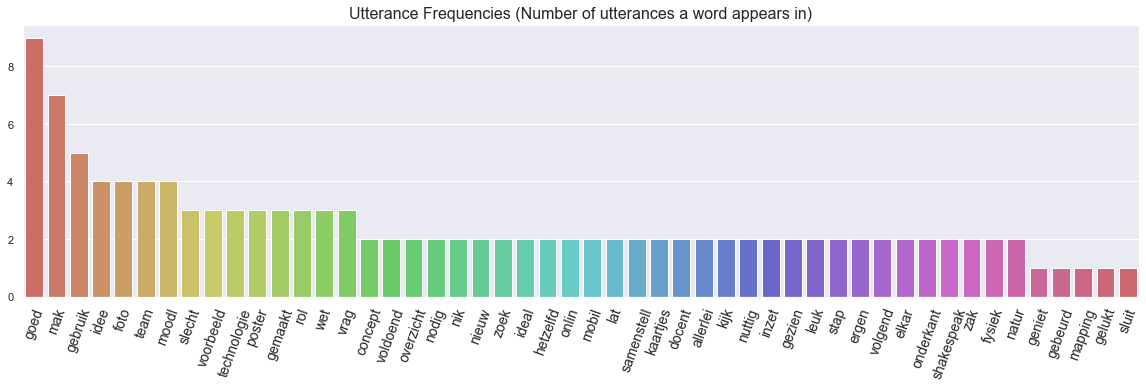

In [6]:
#Remove words that mean little
#As stated above, words the have little meaning to the model are words we'd like to remove. 
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('dutch')
    # we'll add our own special word in here 'qwerty'
    #stopwords.append('qwerty')
    #EXTRA LAYER of PERSONALIZED STOPWORD FILTER - Adding more stopwords to remove from our corpus
    #extend is used to append multiple elements to a list
    stopwords.extend(['we','jij','tuurlijk','heel','julli','kun','hebt','zeg','allemaal','wet','weten','erachter','wel','ok','s','jullie','nou','gaat','gegaan','komen','komt','zitten','allemal','denk','wet','kijk','hoeft','to','rollen'])
    stopwords.extend(converted_stoplines)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(train_data)

#Stemming
#For the stemming part, we'll start with lemmatization, this will stem words like leaves to leaf. 
#Afterwards, we'll apply the porterstemmer which in turn will complete the stemming by converting words like running to run.

def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.snowball.SnowballStemmer("dutch")
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(train_data)

#Vectorize words
#Here we create a dictionary for the model. 
#Since a computer can't reallly understand what a word means, 
#we need to transform it into some number the model will be able to work with. 
#We use gensim.corpora.Dictionary for this.

dictionary = Dictionary(documents=train_data.stemmed_text.values)
## NECESSARY for GUIDED LDA
#corpus_guidedlda = [dictionary.doc2bow(text) for text in train_data.stemmed_text.values]

print("Found {} words.".format(len(dictionary.values())))

#Remove only the top 20% of words since we're dealing with a relatively small dataset here. 
#Also words that occur less than 3 times are removed.
#Can change these values to change the threshold!!
#dictionary.filter_extremes(no_above=0.8, no_below=2) #REMOVE this FILTER

dictionary.compactify()  # Reindexes the remaining words after filtering
#print("Left with {} words.".format(len(dictionary.values())))

#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(train_data)

#Function for all LDA pre-processing
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)

##For guided LDA PRE-PROCESSING
#https://www.kaggle.com/raghulraj/raghulraj-notebook
train_data['cleaned']=train_data.apply(lambda x: ' '.join(x['stemmed_text']),axis=1)

#Visualize the cleansed words frequencies
#Excellent! We cleansed our data and are ready to continue with LDA and Word2Vec, 
#but before we do that, I would like to visualize the cleansed results and see what we created so far.

cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

cleansed_words_df.sort_values('count', ascending=False, inplace=True)

ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Utterance Frequencies (Number of utterances a word appears in)", fontsize=16);

## Plot the word frequencies per group member <a class="anchor" id="C3_6"></a>

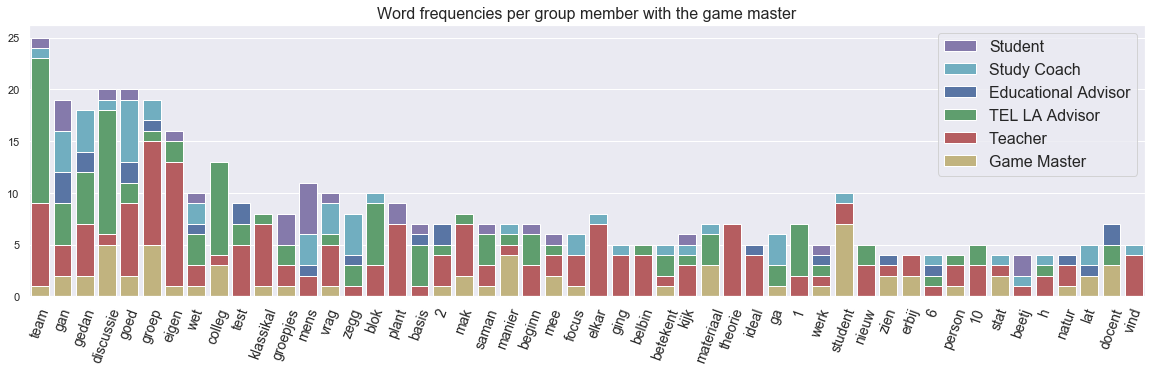

In [7]:
##WITH the Game Master

GM_words = list(np.concatenate(train_data.loc[train_data.author == '1', 'stemmed_text'].values))
TE_words = list(np.concatenate(train_data.loc[train_data.author == '2', 'stemmed_text'].values))
LA_words = list(np.concatenate(train_data.loc[train_data.author == '3', 'stemmed_text'].values))
INTEDU_words = list(np.concatenate(train_data.loc[train_data.author == '5', 'stemmed_text'].values))
SC_words = list(np.concatenate(train_data.loc[train_data.author == '4', 'stemmed_text'].values))
Stud_words = list(np.concatenate(train_data.loc[train_data.author == '6', 'stemmed_text'].values))


GM_word_frequencies = {word: GM_words.count(word) for word in cleansed_words_df.index[:50]}
TE_word_frequencies = {word: TE_words.count(word) for word in cleansed_words_df.index[:50]}
LA_word_frequencies = {word: LA_words.count(word) for word in cleansed_words_df.index[:50]}
INTEDU_word_frequencies = {word: INTEDU_words.count(word) for word in cleansed_words_df.index[:50]}
SC_word_frequencies = {word: SC_words.count(word) for word in cleansed_words_df.index[:50]}
Stud_word_frequencies = {word: Stud_words.count(word) for word in cleansed_words_df.index[:50]}

frequencies_df = pd.DataFrame(index=cleansed_words_df.index[:50])

frequencies_df['GM_freq'] = list(map(lambda word:
                                      GM_word_frequencies[word],
                                      frequencies_df.index))
frequencies_df['GM_TE_freq'] = list(map(lambda word:
                                          GM_word_frequencies[word] + TE_word_frequencies[word],
                                          frequencies_df.index))
frequencies_df['GM_TE_LA_freq'] = list(map(lambda word:
                                              GM_word_frequencies[word] + TE_word_frequencies[word] + LA_word_frequencies[word],
                                              frequencies_df.index))
frequencies_df['GM_TE_LA_INTEDU_freq'] = list(map(lambda word:
                                              GM_word_frequencies[word] + TE_word_frequencies[word] + LA_word_frequencies[word] + INTEDU_word_frequencies[word],
                                              frequencies_df.index))
frequencies_df['GM_TE_LA_INTEDU_SC_freq'] = list(map(lambda word:
                                              GM_word_frequencies[word] + TE_word_frequencies[word] + LA_word_frequencies[word] + INTEDU_word_frequencies[word] + SC_word_frequencies[word],
                                              frequencies_df.index))
frequencies_df['GM_TE_LA_INTEDU_SC_Stud_freq'] = list(map(lambda word:
                                              GM_word_frequencies[word] + TE_word_frequencies[word] + LA_word_frequencies[word] + INTEDU_word_frequencies[word] + SC_word_frequencies[word] + Stud_word_frequencies[word],
                                              frequencies_df.index))

#Plot these frequencies in a stacked bar chart

fig, ax = plt.subplots(1,1,figsize=(20,5))

nr_top_words = len(frequencies_df)
nrs = list(range(nr_top_words))

sns.barplot(nrs, frequencies_df['GM_TE_LA_INTEDU_SC_Stud_freq'].values, color='m', ax=ax, label="Student")
sns.barplot(nrs, frequencies_df['GM_TE_LA_INTEDU_SC_freq'].values, color='c', ax=ax, label="Study Coach")
sns.barplot(nrs, frequencies_df['GM_TE_LA_INTEDU_freq'].values, color='b', ax=ax, label="Educational Advisor")
sns.barplot(nrs, frequencies_df['GM_TE_LA_freq'].values, color='g', ax=ax, label="TEL LA Advisor")
sns.barplot(nrs, frequencies_df['GM_TE_freq'].values, color='r', ax=ax, label="Teacher")
sns.barplot(nrs, frequencies_df['GM_freq'].values, color='y', ax=ax, label="Game Master")

ax.set_title("Word frequencies per group member with the game master", fontsize=16)
ax.legend(prop={'size': 16})
ax.set_xticks(nrs)
ax.set_xticklabels(frequencies_df.index, fontsize=14, rotation=70);

In [8]:
##WITHOUT the Game Master

#GM_words = list(np.concatenate(train_data.loc[train_data.author == '1', 'stemmed_text'].values))
TE_words = list(np.concatenate(train_data.loc[train_data.author == '2', 'stemmed_text'].values))
LA_words = list(np.concatenate(train_data.loc[train_data.author == '3', 'stemmed_text'].values))
INTEDU_words = list(np.concatenate(train_data.loc[train_data.author == '5', 'stemmed_text'].values))
SC_words = list(np.concatenate(train_data.loc[train_data.author == '4', 'stemmed_text'].values))
Stud_words = list(np.concatenate(train_data.loc[train_data.author == '6', 'stemmed_text'].values))

#GM_word_frequencies = {word: GM_words.count(word) for word in cleansed_words_df.index[:50]}
TE_word_frequencies = {word: TE_words.count(word) for word in cleansed_words_df.index[:50]}
LA_word_frequencies = {word: LA_words.count(word) for word in cleansed_words_df.index[:50]}
INTEDU_word_frequencies = {word: INTEDU_words.count(word) for word in cleansed_words_df.index[:50]}
SC_word_frequencies = {word: SC_words.count(word) for word in cleansed_words_df.index[:50]}
Stud_word_frequencies = {word: Stud_words.count(word) for word in cleansed_words_df.index[:50]}

frequencies_df = pd.DataFrame(index=cleansed_words_df.index[:50])

#frequencies_df['GM_freq'] = list(map(lambda word:
                                      #GM_word_frequencies[word],
                                      #frequencies_df.index))
frequencies_df['TE_freq'] = list(map(lambda word:
                                          TE_word_frequencies[word],
                                          frequencies_df.index))
frequencies_df['TE_LA_freq'] = list(map(lambda word:
                                              TE_word_frequencies[word] + LA_word_frequencies[word],
                                              frequencies_df.index))
frequencies_df['TE_LA_INTEDU_freq'] = list(map(lambda word:
                                              TE_word_frequencies[word] + LA_word_frequencies[word] + INTEDU_word_frequencies[word],
                                              frequencies_df.index))
frequencies_df['TE_LA_INTEDU_SC_freq'] = list(map(lambda word:
                                              TE_word_frequencies[word] + LA_word_frequencies[word] + INTEDU_word_frequencies[word] + SC_word_frequencies[word],
                                              frequencies_df.index))
frequencies_df['TE_LA_INTEDU_SC_Stud_freq'] = list(map(lambda word:
                                              TE_word_frequencies[word] + LA_word_frequencies[word] + INTEDU_word_frequencies[word] + SC_word_frequencies[word] + Stud_word_frequencies[word],
                                              frequencies_df.index))

#Plot these frequencies in a stacked bar chart

fig, ax = plt.subplots(1,1,figsize=(20,5))

nr_top_words = len(frequencies_df)
nrs = list(range(nr_top_words))

sns.barplot(nrs, frequencies_df['TE_LA_INTEDU_SC_Stud_freq'].values, color='m', ax=ax, label="Student")
sns.barplot(nrs, frequencies_df['TE_LA_INTEDU_SC_freq'].values, color='c', ax=ax, label="Study Coach")
sns.barplot(nrs, frequencies_df['TE_LA_INTEDU_freq'].values, color='b', ax=ax, label="Educational Advisor")
sns.barplot(nrs, frequencies_df['TE_LA_freq'].values, color='g', ax=ax, label="TEL LA Advisor")
sns.barplot(nrs, frequencies_df['TE_freq'].values, color='r', ax=ax, label="Teacher")
#sns.barplot(nrs, frequencies_df['GM_freq'].values, color='y', ax=ax, label="Game Master")

ax.set_title("Word frequencies per group member without the game master", fontsize=16)
ax.legend(prop={'size': 16})
ax.set_xticks(nrs)
ax.set_xticklabels(frequencies_df.index, fontsize=14, rotation=70);

ValueError: need at least one array to concatenate

## Topic modeling using LDA (Latent Dirichlet Allocation) <a class="anchor" id="C3_7"></a>

TypeError: object of type 'float' has no len()

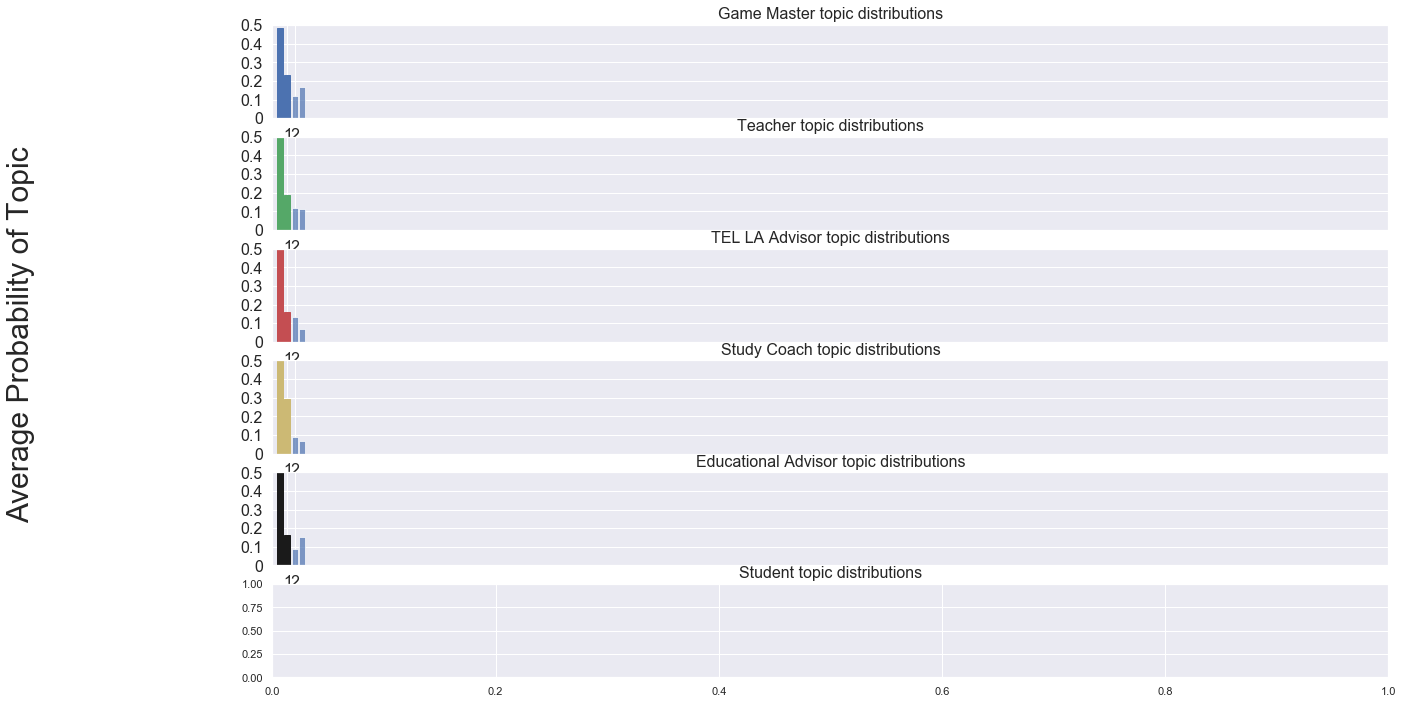

In [24]:
#https://stackoverflow.com/questions/15067734/lda-model-generates-different-topics-everytime-i-train-on-the-same-corpus
#https://www.kaggle.com/vukglisovic/classification-combining-lda-and-word2vec/
#LDA Training
#https://stackoverflow.com/questions/15067734/lda-model-generates-different-topics-everytime-i-train-on-the-same-corpus

corpus = train_data.bow
#time
num_topics = 4
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=100,
                        passes=7,
                        alpha='asymmetric')
#https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/
#alpha represents document-topic density
#Beta represents topic-word density

#LDA topic inspection
#Create the feature vectors.
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

train_data['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      train_data.bow))

#Group member specific topic distributions
GM_topic_distribution = train_data.loc[train_data.author == '1', 'lda_features'].mean()
TE_topic_distribution = train_data.loc[train_data.author == '2', 'lda_features'].mean()
LA_topic_distribution = train_data.loc[train_data.author == '3', 'lda_features'].mean()
SC_topic_distribution = train_data.loc[train_data.author == '4', 'lda_features'].mean()
INTEDU_topic_distribution = train_data.loc[train_data.author == '5', 'lda_features'].mean()
Stud_topic_distribution = train_data.loc[train_data.author == '6', 'lda_features'].mean()


fig, [ax1,ax2,ax3,ax4,ax5,ax6] = plt.subplots(6,1,figsize=(20,12))

nr_top_bars = 2

ax1.set_title("Game Master topic distributions", fontsize=16)
ax2.set_title("Teacher topic distributions", fontsize=16)
ax3.set_title("TEL LA Advisor topic distributions", fontsize=16)
ax4.set_title("Study Coach topic distributions", fontsize=16)
ax5.set_title("Educational Advisor topic distributions", fontsize=16)
ax6.set_title("Student topic distributions", fontsize=16)

ax3.text(-35, 0.04, "Average Probability of Topic", fontsize=30, ha="center", va="center",
         rotation="vertical")

for ax, distribution, color in zip([ax1,ax2,ax3,ax4,ax5,ax6],
                                   [GM_topic_distribution,TE_topic_distribution,LA_topic_distribution,SC_topic_distribution,INTEDU_topic_distribution,Stud_topic_distribution],
                                   ['b','g','r','y','k','m']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, 150)
    ax.set_xticks(range(1,3,1))
    ax.set_xticklabels(range(1,3,1), fontsize=16)
    ax.set_ylim(0,0.5)
    ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
    ax.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5], fontsize=16)

fig.tight_layout(h_pad=10.)

In [25]:
#Words these topics contain
#Number of top words shown in each topic
def get_topic_top_words(lda_model, topic_id, nr_top_words=10):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

for author, distribution in zip(['Game Master', 'Teacher', 'TEL LA Advisor','Study Coach','Educational Advisor','Student'], [GM_topic_distribution,TE_topic_distribution,LA_topic_distribution,SC_topic_distribution,INTEDU_topic_distribution,Stud_topic_distribution]):
    print("Looking up top words from top topics from {}.".format(author))
    #Number of topics to be shown
    for x in sorted(np.argsort(distribution)[-4:]):
        top_words = get_topic_top_words(LDAmodel, x)
        print("For topic {}, the top words are: {}.".format(x, ", ".join(top_words)))
    print("")

Looking up top words from top topics from Game Master.
For topic 0, the top words are: goed, mak, gebruik, team, foto, idee, vrag, voorbeeld, gemaakt, stap.
For topic 1, the top words are: moodl, wet, klopt, inzet, rol, bezig, vorig, kijk, geniet, duidelijk.
For topic 2, the top words are: stat, bovenkant, gezegd, voldoend, shakespeak, sendstep, smart, docent, mee, onderkant.
For topic 3, the top words are: gezien, kijk, slecht, rod, poster, kaart, goed, mi, deelonderwerp, saman.

Looking up top words from top topics from Teacher.
For topic 0, the top words are: goed, mak, gebruik, team, foto, idee, vrag, voorbeeld, gemaakt, stap.
For topic 1, the top words are: moodl, wet, klopt, inzet, rol, bezig, vorig, kijk, geniet, duidelijk.
For topic 2, the top words are: stat, bovenkant, gezegd, voldoend, shakespeak, sendstep, smart, docent, mee, onderkant.
For topic 3, the top words are: gezien, kijk, slecht, rod, poster, kaart, goed, mi, deelonderwerp, saman.

Looking up top words from top to

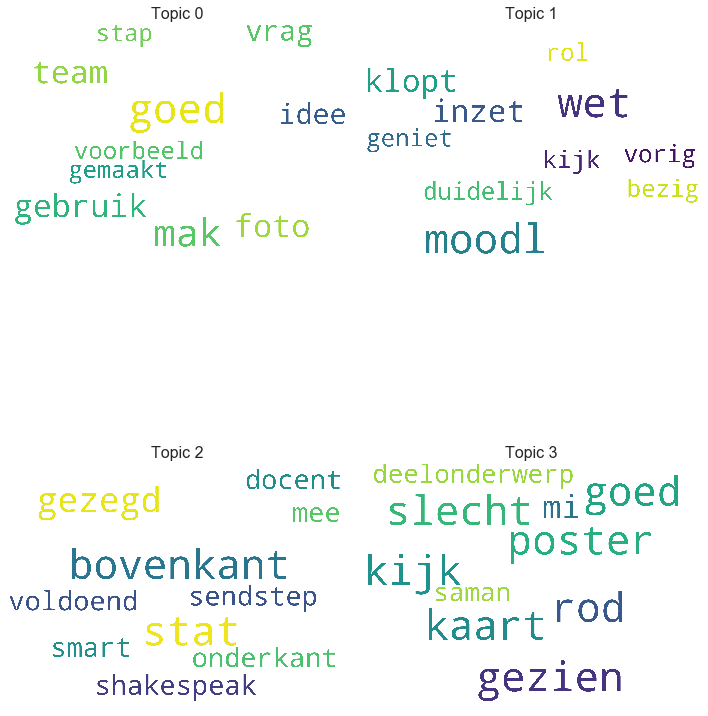

In [26]:
#Make a wordcloud for each topics to see the few important words in terms of their probability distribution
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
    
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(#stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  #colormap='tab10',
                  #color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = LDAmodel.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Topic modeling using LSA (Latent Semantic Analysis) <a class="anchor" id="C3_8"></a>

In [18]:
#print(topics)
#print(num_topic)
print(train_data.stemmed_text)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in train_data.stemmed_text]
print(doc_term_matrix)

author
1                                               [sluit]
2     [tijd, overweg, volgend, stap, bestat, kijk, i...
3                                                    []
4                                         [onderstaand]
5                                      [typ, onderkant]
                            ...                        
77                                            [student]
78                                              [lever]
79                               [moodl, daarvor, ligg]
80                                          [specifiek]
81                   [goed, powerpoint, ofzo, techniek]
Name: stemmed_text, Length: 81, dtype: object
[[(0, 1)], [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1)], [], [(17, 1)], [(18, 1), (19, 1)], [(18, 1), (20, 1), (21, 3), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 3), (30, 1), (31, 1)], [(32, 1), (33, 1), (34, 1), (

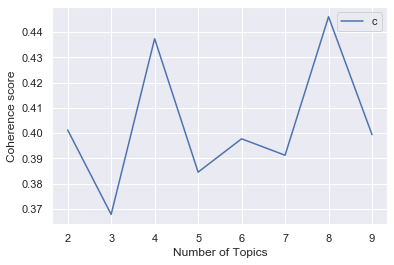

In [21]:
## https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel


def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,10,1
plot_graph(train_data.stemmed_text,start,stop,step)


In [20]:
number_of_topics=8
words=10

#document_list,titles=load_data("","articles.txt")
model=create_gensim_lsa_model(train_data.stemmed_text,number_of_topics,words)

[(0, '-0.554*"stat" + -0.554*"bovenkant" + -0.199*"kaartjes" + -0.191*"onderkant" + -0.185*"blauw" + -0.185*"enhanc" + -0.185*"brengt" + -0.185*"deurn" + -0.185*"ler" + -0.185*"stukj"'), (1, '-0.400*"kijk" + -0.383*"kaart" + -0.383*"rod" + -0.255*"voorbeeld" + -0.228*"stap" + -0.211*"volgend" + -0.211*"nuttig" + -0.191*"aantal" + -0.191*"bestat" + -0.191*"erbij"'), (2, '-0.456*"mak" + -0.352*"goed" + -0.268*"gebruik" + -0.257*"poster" + -0.207*"nodig" + -0.207*"nik" + -0.201*"allerlei" + -0.181*"foto" + -0.154*"overzicht" + -0.149*"natur"'), (3, '-0.828*"moodl" + -0.222*"set" + -0.222*"leg" + -0.222*"beschrijf" + -0.222*"stad" + -0.222*"digital" + -0.204*"kaartjes" + -0.059*"redelijk" + -0.059*"sowieso" + -0.059*"laatst"'), (4, '0.468*"goed" + 0.375*"slecht" + 0.237*"voorbeeld" + -0.208*"gebruik" + 0.177*"gezien" + -0.175*"gezegd" + -0.168*"natur" + -0.160*"technologie" + 0.148*"vrag" + -0.146*"nik"'), (5, '-0.385*"gezegd" + -0.385*"slecht" + -0.277*"docent" + -0.272*"technologie" + -0

## Generate the knowledge graph <a class="anchor" id="C3_9"></a>

London is the capital and largest city of England and the United Kingdom. Standing on the River Thames in the south-east of England, at the head of its 50-mile (80 km) estuary leading to the North Sea, London has been a major settlement for two millennia. Londinium was founded by the Romans. The City of London, London's ancient core − an area of just 1.12 square miles (2.9 km2) and colloquially known as the Square Mile − retains boundaries that follow closely its medieval limits.The City of Westminster is also an Inner London borough holding city status. Greater London is governed by the Mayor of London and the London Assembly.London is located in the southeast of England.Westminster is located in London.London is the biggest city in Britain. London has a population of 7,172,036.
London -> nsubj
is -> ROOT
the -> det
capital -> attr
and -> cc
largest -> amod
city -> conj
of -> prep
England -> pobj
and -> cc
the -> det
United -> compound
Kingdom -> conj
. -> punct
London , be capital la

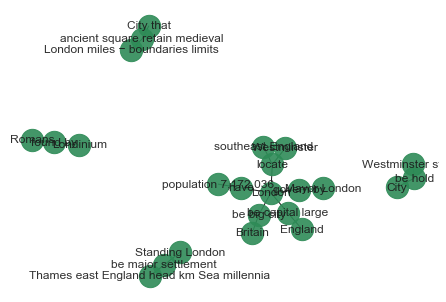

In [42]:
#https://github.com/explosion/spaCy/issues/4577 #Solve the spacy model download error
#https://github.com/bdmarius/python-knowledge-graph #Make a knowledge graph in English

import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt
#pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

def getSentences(text):
    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]

def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    plt.figure()
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})
    plt.axis('off')
    plt.show()

if __name__ == "__main__":

    text = "London is the capital and largest city of England and the United Kingdom. Standing on the River " \
           "Thames in the south-east of England, at the head of its 50-mile (80 km) estuary leading to " \
           "the North Sea, London has been a major settlement for two millennia. " \
           "Londinium was founded by the Romans. The City of London, " \
           "London's ancient core − an area of just 1.12 square miles (2.9 km2) and colloquially known as " \
           "the Square Mile − retains boundaries that follow closely its medieval limits." \
           "The City of Westminster is also an Inner London borough holding city status. " \
           "Greater London is governed by the Mayor of London and the London Assembly." \
           "London is located in the southeast of England." \
           "Westminster is located in London." \
           "London is the biggest city in Britain. London has a population of 7,172,036."

    sentences = getSentences(text)
    nlp_model = spacy.load('en_core_web_sm')
    #nlp_model = en_core_web_sm.load()

    triples = []
    print (text)
    for sentence in sentences:
        triples.append(processSentence(sentence))

    printGraph(triples)

nou de voorbereidingen gedaan dan ja zijn allemaal willekeurig ja ik heb ook niet zoveel bij iemand iets neergelegd ik heb even gezorgd dat de student en docent dat die alle typen kaartjes  hebben ze dat makkelijk voor jullie liggen ze daar ook ja gewoon  google dahua wel een hoesje omheen zit mag ook echt opschrijven en stiften  watervaste en whiteboard marker stift oké stop doe ik eerst even met je moet ik eerst even met jullie over praten hebben we het vandaag over discussie college van week 1 juli. onderuit. varsseveld. misten. ja ja. individueel activiteiten. en wat. staat ook achter op het bord. de vier onderwerpen die in dat. college langskomen zijn de onderwerpen 10 focus teamrollen zijn is het onderwerp je eigen piemel verder ervaring in het kader van de belbin rollen en belde rollen belde is een zelf toets waarin dat je een dat je een aantal verschillende rollen hebt die bepaalde bijdrage hebben in een groepsapp proces adres dat ingevuld dus beter van zichzelf ik heb dingen d

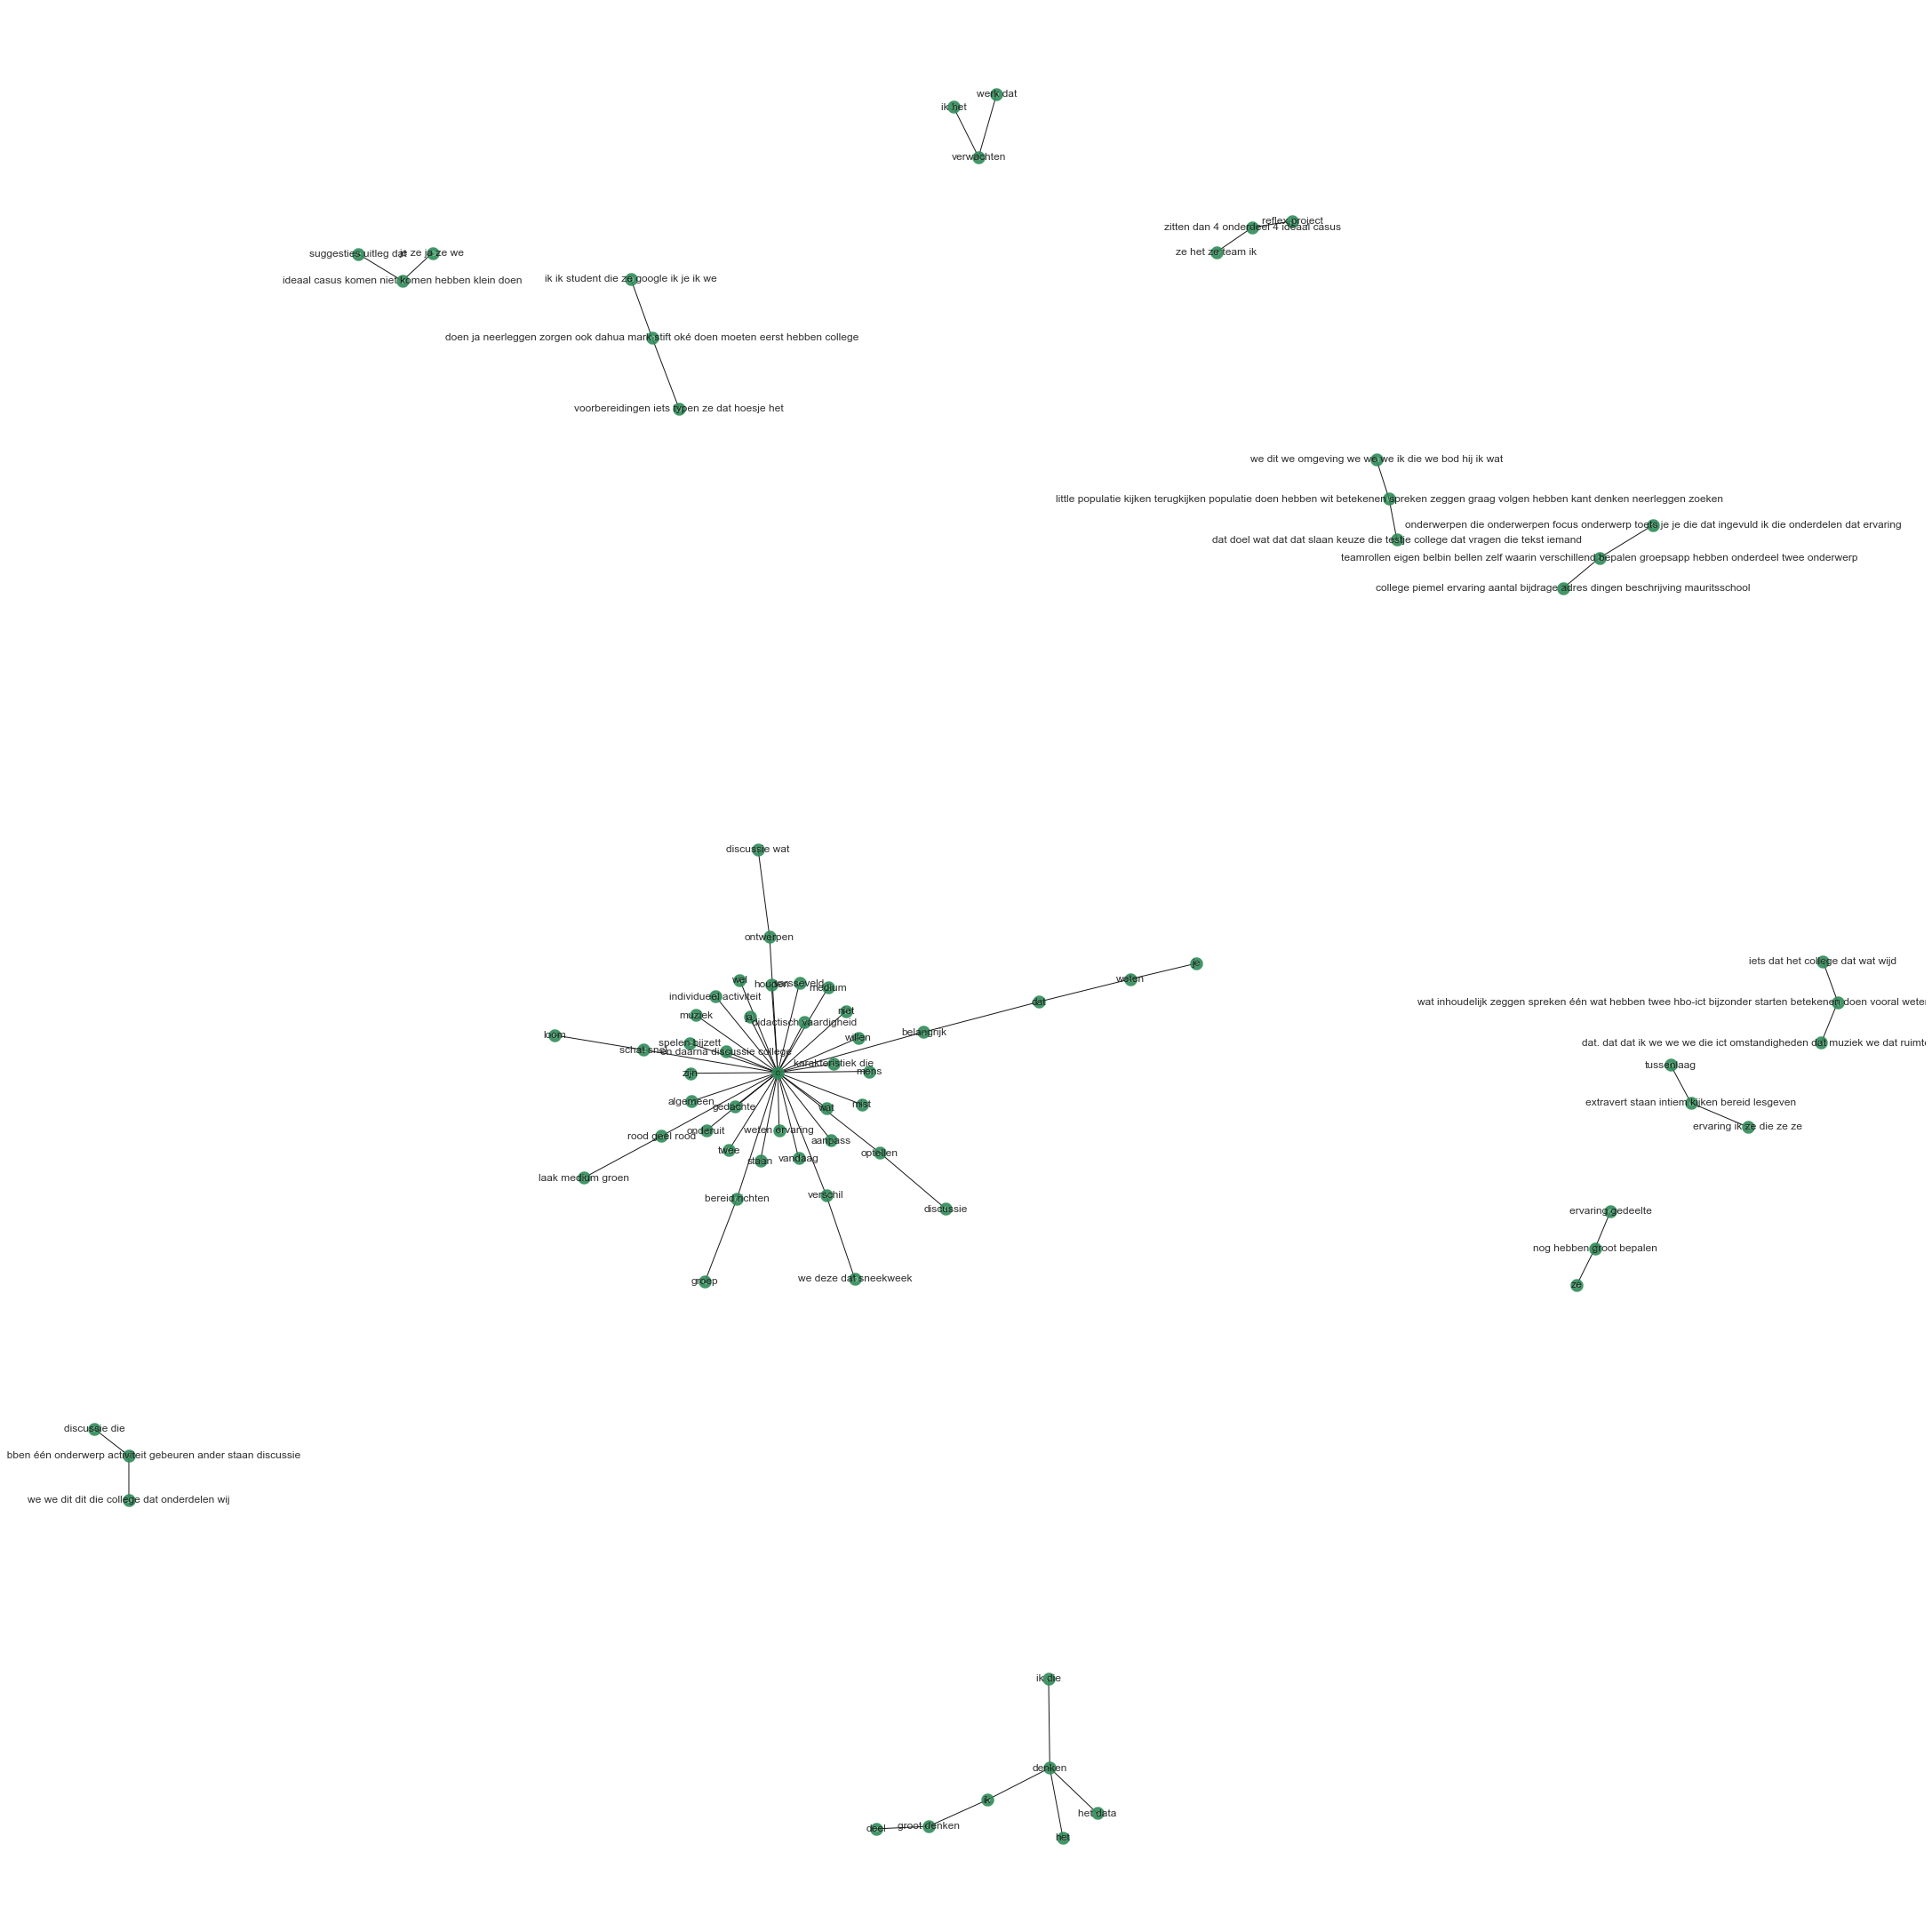

In [108]:
#https://github.com/explosion/spaCy/issues/4577 #Solve the spacy model download error
#https://github.com/bdmarius/python-knowledge-graph #Make a knowledge graph in English

import spacy
from spacy.lang.nl import Dutch
import networkx as nx
import matplotlib.pyplot as plt
#pip3 install https://github.com/explosion/spacy-models/releases/download/nl_core_news_sm-2.3.0/nl_core_news_sm-2.3.0.tar.gz
def getSentences(text):
    nlp = Dutch()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]

def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G) #nx.circular_layout(G) #nx.spring_layout(G)
    plt.figure(3,figsize=(30,30))
    nx.draw(G, pos, edge_color='black', width=1, linewidths=10,
            node_size=20, node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})
    plt.axis('off')
    plt.show()
    
#print(train_data['text'].tolist())
train_data_knowledge_processed = ""
train_data_knowledge = [i.strip() + ". " for i in train_data['text'].tolist()]
i = 0
#print(train_data_knowledge[0])
for j in train_data_knowledge:
    train_data_knowledge_processed += train_data_knowledge[i]
    i = i+1
#print(train_data_knowledge_processed)

if __name__ == "__main__":

    text = train_data_knowledge_processed
    
    sentences = getSentences(text)
    nlp_model = spacy.load('nl_core_news_sm')

    triples = []
    print (text)
    for sentence in sentences:
        triples.append(processSentence(sentence))

    printGraph(triples)

In [4]:
print(sentences)

['Londen is de hoofdstad en grootste stad van Engeland en het Verenigd Koninkrijk.', 'Staande op de rivier Theems in het zuidoosten van Engeland, aan het begin van de 80 km lange monding die naar de Noordzee is Londen al tweeduizend jaar een belangrijke nederzetting.']


In [9]:
#https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-language-model-nlp-python-code/
#nltk.download('reuters')
from nltk.corpus import reuters
from nltk import bigrams, trigrams
from collections import Counter, defaultdict

# Create a placeholder for model
model = defaultdict(lambda: defaultdict(lambda: 0))

# Count frequency of co-occurance  
for sentence in reuters.sents():
    for w1, w2, w3 in trigrams(sentence, pad_right=True, pad_left=True):
        model[(w1, w2)][w3] += 1
 
# Let's transform the counts to probabilities
for w1_w2 in model:
    total_count = float(sum(model[w1_w2].values()))
    for w3 in model[w1_w2]:
        model[w1_w2][w3] /= total_count

In [20]:
dict(model["today", "the"])

{'public': 0.05555555555555555,
 'European': 0.05555555555555555,
 'Bank': 0.05555555555555555,
 'price': 0.1111111111111111,
 'emirate': 0.05555555555555555,
 'overseas': 0.05555555555555555,
 'newspaper': 0.05555555555555555,
 'company': 0.16666666666666666,
 'Turkish': 0.05555555555555555,
 'increase': 0.05555555555555555,
 'options': 0.05555555555555555,
 'Higher': 0.05555555555555555,
 'pound': 0.05555555555555555,
 'Italian': 0.05555555555555555,
 'time': 0.05555555555555555}

In [35]:
#https://github.com/EricFillion/N-Grams/blob/master/ngrams.py

def trigram(doc):
    # create a list for the result
    result = list()
    # create a list that contains no punctuation
    sentence = list()
    # parse through the document to add all tokens that are words to the sentence list
    for token in doc:
        if token.is_alpha:
            sentence.append(token)
    # parse through the sentence while adding words in groups of two to the result
    for word in range(len(sentence) - 2):
        first_word = sentence[word]
        second_word = sentence[word + 1]
        third_word = sentence[word + 2]
        element = [first_word.text, second_word.text, third_word.text]
        result.append(element)

    return result

In [37]:
import spacy
from spacy.lang.nl import Dutch

def main():
    # load Dutch language
    nlp = Dutch()

    # create a document
    doc = nlp("Ik zou graag met je willen spelen, op voorwaarde dat je met mij speelt. Ik van hou")

    result = trigram(doc)

    for element in result:
        for token in element:
            print(token, end=' ')
        print()  # new line

main()

Ik zou graag 
zou graag met 
graag met je 
met je willen 
je willen spelen 
willen spelen op 
spelen op voorwaarde 
op voorwaarde dat 
voorwaarde dat je 
dat je met 
je met mij 
met mij speelt 
mij speelt Ik 
speelt Ik van 
Ik van hou 


In [29]:
#https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/

import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

## Find the number of exchanges or turn-taking between group members <a class="anchor" id="C3_10"></a>

In [27]:
## https://stackoverflow.com/questions/12488722/counting-bigrams-pair-of-two-words-in-a-file-using-python

def ngrams(lst, n):
  tlst = lst
  while True:
    a, b = tee(tlst)
    l = tuple(islice(a, n))
    if len(l) == n:
      yield l
      next(b)
      tlst = b
    else:
      break

#Counter_ngrams = 
Counter_ngrams = Counter(ngrams(train_data['author'].tolist(), 3))
#print(ngrams(train_data['author'].tolist(), 3))
print(Counter_ngrams)
#print(Counter_ngrams[('1', '1', '1')])

Counter({('2', '3', '2'): 5, ('3', '2', '3'): 4, ('3', '1', '3'): 4, ('2', '1', '2'): 3, ('4', '5', '4'): 3, ('2', '3', '5'): 3, ('3', '2', '1'): 3, ('1', '3', '1'): 3, ('2', '1', '4'): 2, ('1', '4', '5'): 2, ('5', '4', '5'): 2, ('1', '3', '2'): 2, ('3', '5', '3'): 2, ('4', '2', '3'): 2, ('3', '2', '5'): 2, ('5', '2', '3'): 2, ('5', '4', '1'): 2, ('4', '1', '4'): 2, ('1', '4', '3'): 2, ('4', '3', '2'): 2, ('3', '4', '3'): 2, ('4', '5', '2'): 1, ('5', '2', '1'): 1, ('1', '2', '5'): 1, ('2', '5', '1'): 1, ('5', '1', '4'): 1, ('5', '4', '2'): 1, ('4', '2', '1'): 1, ('1', '4', '1'): 1, ('4', '1', '3'): 1, ('5', '3', '4'): 1, ('3', '4', '2'): 1, ('5', '3', '2'): 1, ('1', '2', '3'): 1, ('2', '5', '2'): 1, ('1', '2', '1'): 1, ('2', '1', '3'): 1, ('2', '1', '5'): 1, ('1', '5', '4'): 1, ('2', '5', '4'): 1, ('3', '5', '2'): 1, ('3', '2', '4'): 1, ('2', '4', '2'): 1, ('2', '3', '4'): 1, ('4', '3', '4'): 1, ('4', '3', '1'): 1})


In [62]:
#https://heartbeat.fritz.ai/nlp-chronicles-intro-to-spacy-34949f1bc118#2930
nlp = spacy.load("nl_core_news_sm")
doc = nlp(u"Nou de voorbereidingen gedaan dan Ja zijn allemaal willekeurig Ja ik heb ook niet zoveel bij iemand iets neergelegd Ik heb even gezorgd dat de student en docent dat die alle typen kaartjes hebben ze dat makkelijk voor jullie liggen ze daar ook ja gewoon Google dahua wel een hoesje omheen zit mag ook echt opschrijven en stiften watervaste en whiteboard Marker stift oke stop doe ik eerst even met je moet ik eerst even met jullie over praten hebben we het vandaag over discussie College van week 1 juli ")
for sent in doc.sents:
    print(sent)

Nou de voorbereidingen gedaan dan Ja zijn allemaal willekeurig
Ja ik heb ook niet zoveel bij iemand iets neergelegd
Ik heb even gezorgd dat de student en docent dat die alle typen kaartjes hebben ze dat makkelijk voor jullie liggen ze daar
ook ja gewoon
Google dahua wel een hoesje omheen zit mag ook echt opschrijven en stiften watervaste en whiteboard
Marker stift oke stop
doe ik eerst even met
je moet ik eerst even met jullie
over praten hebben we het vandaag over discussie
College van week 1 juli


bijvoorbeeld ook een. zo. ik krijg hier shakespeak action. de overzicht gaan we nu allerlei tools bedenken of want we zitten natuurlijk gewoon fysiek bij elkaar ja je hoeft het niet zo moeilijk te maken dan dat nodig dus niks. dan zou je eventueel ook en ik zal hier ergens mobile phone kun je gebruiken om een foto te maken van de poster dieter ja heb je niks nodig. en  video  zo ook als docent  energizer of gewoon als soort voorbeeld slechte zaak. voorbeelden denk ik online om goede en slechte voorbeelden  dat zou je misschien als. discussie. tuurlijk ook vragen van blof te schrijven maar goed het zit allemaal niet in de opdracht dus ik zou. ja. moeten voorbereiden of niet. dat je alleen flipover voldoende hebt. fysiek bij elkaar  zou ik het niet zoeken in de technologie  ik zou het dan niet daarin gebruiken maar vooral ja laat ze maar. tot gauw  noemen uiteindelijk op basis van de literatuur  het is een ideale samenstelling en de voorwaarden  dat het niet dezelfde groep. te doen met h

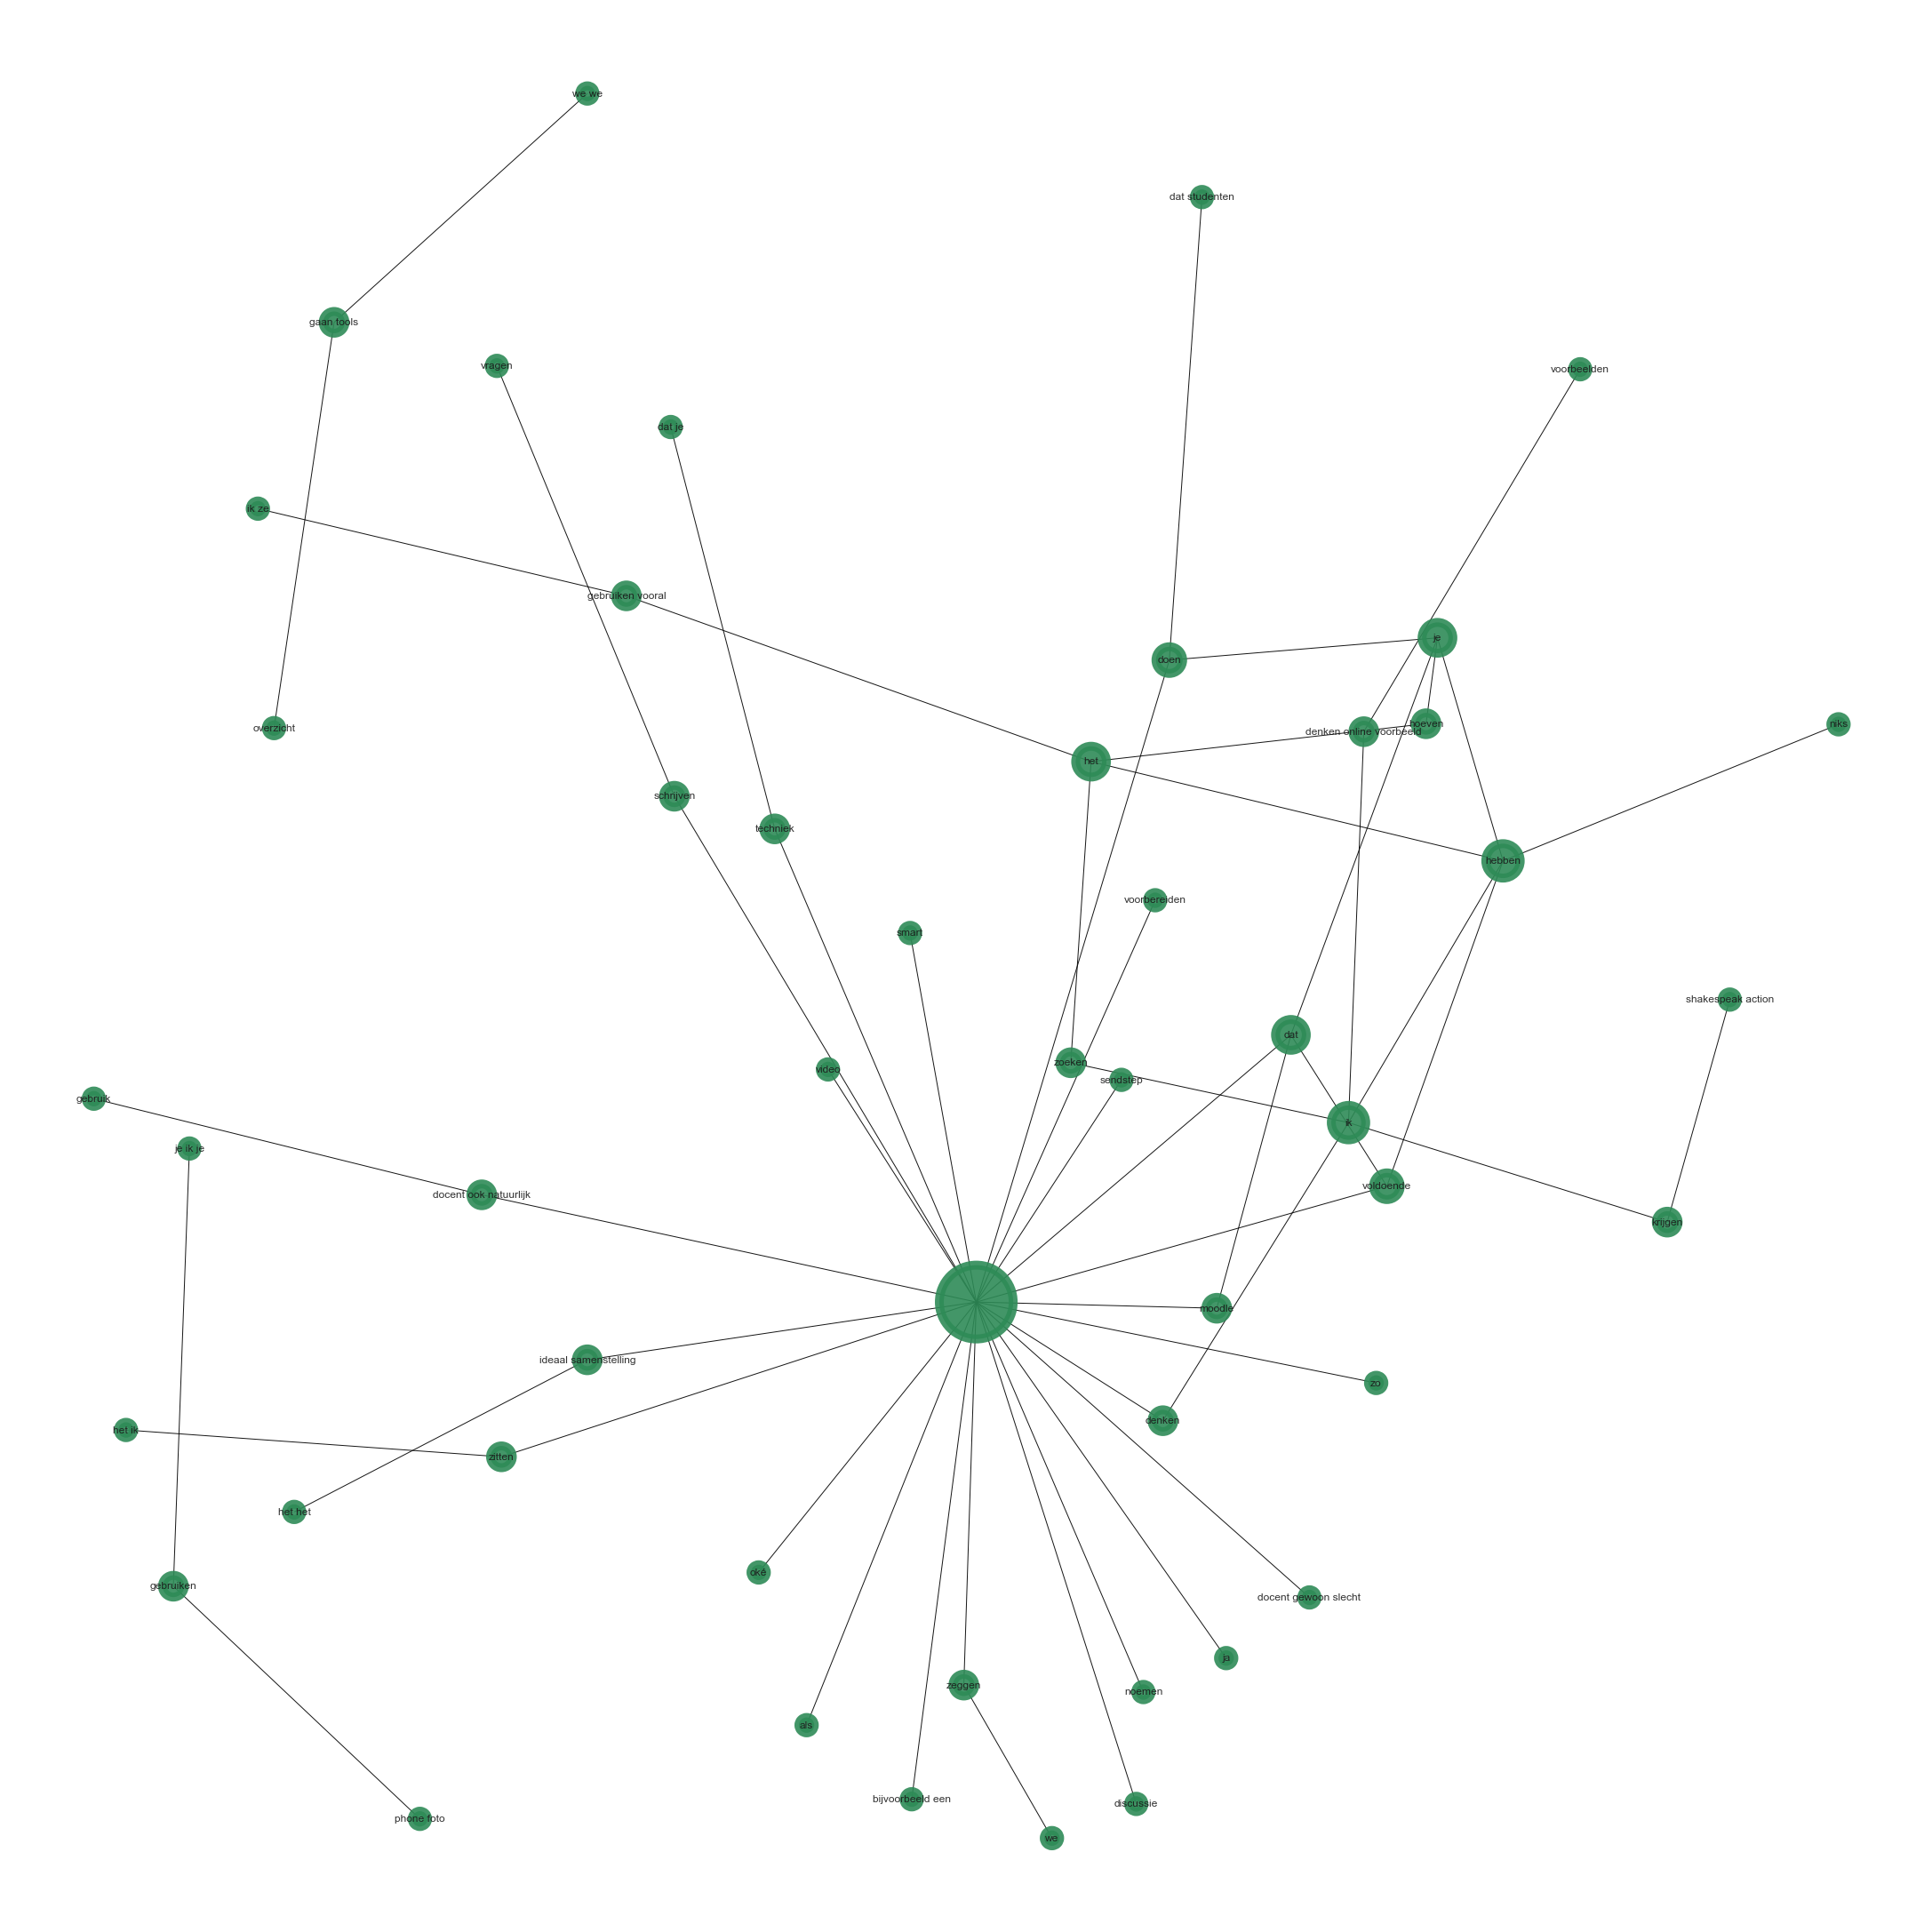

In [12]:
#https://github.com/explosion/spaCy/issues/4577 #Solve the spacy model download error
#https://github.com/bdmarius/python-knowledge-graph #Make a knowledge graph in English

import spacy
from spacy.lang.nl import Dutch
import networkx as nx
import matplotlib.pyplot as plt
#pip3 install https://github.com/explosion/spacy-models/releases/download/nl_core_news_sm-2.3.0/nl_core_news_sm-2.3.0.tar.gz
#https://heartbeat.fritz.ai/nlp-chronicles-intro-to-spacy-34949f1bc118#2930
def getSentences(text):
    nlp = spacy.load('nl_core_news_sm')
    #nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]

def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])
# https://stackoverflow.com/questions/60919360/make-networkx-plot-look-nice
#https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/
    pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order())) #nx.circular_layout(G) #nx.spring_layout(G)
    plt.figure(3,figsize=(30,30))
    d = dict(G.degree)
    nx.draw(G, pos, edge_color='black', width=1, linewidths=10, nodelist=d,
            node_size=[d[k]*300 for k in d], node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})
    plt.axis('off')
    plt.show()
    
#print(train_data['text'].tolist())
train_data_knowledge_processed = ""
#select a subset of datframe for certain group member(s)
#https://thispointer.com/python-pandas-select-rows-in-dataframe-by-conditions-on-multiple-columns/
subset_train_data = train_data[train_data['author'].isin(['3'])] #Select 1 or more group members #[train_data['author'] == '1']
#subset_train_data = train_data[train_data['author'].isin(['1','2','3','4','5'])] #All members in red phase
train_data_knowledge = [i.strip() + ". " for i in subset_train_data['text'].tolist()]
i = 0
#print(train_data_knowledge[0])
for j in train_data_knowledge:
    train_data_knowledge_processed += train_data_knowledge[i]
    i = i+1
#print(train_data_knowledge_processed)

if __name__ == "__main__":

    text = train_data_knowledge_processed
    
    sentences = getSentences(text)
    nlp_model = spacy.load('nl_core_news_sm')

    triples = []
    print (text)
    for sentence in sentences:
        triples.append(processSentence(sentence))

    printGraph(triples)

In [13]:
print(sentences)

['bijvoorbeeld ook een.', 'zo.', 'ik krijg hier shakespeak action.', 'de overzicht gaan we nu allerlei tools bedenken of want we zitten natuurlijk gewoon fysiek bij elkaar', 'ja', 'je hoeft het niet zo moeilijk te maken dan dat nodig dus niks.', 'dan zou je eventueel ook en ik zal hier ergens mobile phone kun je gebruiken om een foto te maken van de poster dieter', 'ja heb je niks nodig.', 'en  video', 'zo ook als docent  energizer of gewoon als soort voorbeeld slechte zaak.', 'voorbeelden denk ik online om goede en slechte voorbeelden', 'dat zou je misschien', 'als.', 'discussie.', 'tuurlijk ook vragen van blof te schrijven maar goed', 'het zit allemaal niet in de opdracht dus ik zou.', 'ja. moeten voorbereiden of niet.', 'dat je alleen flipover voldoende hebt.', 'fysiek bij elkaar  zou ik het niet zoeken in de technologie', 'ik zou het dan niet daarin gebruiken maar vooral ja laat ze maar.', 'tot gauw  noemen uiteindelijk op basis van de literatuur', 'het is een ideale samenstelling 

## Generate bigrams, trigrams, ngram and the co-occurence matrix <a class="anchor" id="C3_11"></a>

In [14]:
# https://www.geeksforgeeks.org/tf-idf-for-bigrams-trigrams/
# Preprocessing 
import re
def remove_string_special_characters(s): 
      
    # removes special characters with ' ' 
    stripped = re.sub('[^a-zA-z\s]', '', s) 
    stripped = re.sub('_', '', stripped) 
      
    # Change any white space to one space 
    stripped = re.sub('\s+', ' ', stripped) 
      
    # Remove start and end white spaces 
    stripped = stripped.strip() 
    if stripped != '': 
            return stripped.lower() 
          
# Stopword removal  
stop_words = nltk.corpus.stopwords.words('dutch')
stop_words.extend(['we','jij','tuurlijk','heel','julli','kun','hebt','zeg','allemaal','wet','weten','erachter','wel','ok','s','jullie','nou','gaat','gegaan','komen','komt','zitten','allemal','denk','weet','kijk','hoeft','to','rollen'])
stop_words.extend(converted_stoplines)
#stop_words = set(stopwords.words('dutch')) 
#your_list = ['skills', 'ability', 'job', 'description'] 
# Also stem the words to group together same words in different form along-with stop word removal
p_stemmer = nltk.stem.snowball.SnowballStemmer("dutch")
for i, line in enumerate(sentences): 
    sentences[i] = ' '.join([p_stemmer.stem(x) for 
        x in nltk.word_tokenize(line) if 
        ( x not in stop_words )]) 
    
# Getting bigrams  #Use (n,n) for n grams, so (2,2) for bigrams and so on
vectorizer = CountVectorizer(ngram_range =(1, 1)) 
X1 = vectorizer.fit_transform(sentences)  
features = (vectorizer.get_feature_names()) 
print("\n\nX1 : \n", X1.toarray()) 
  
# Applying TFIDF 
# You can still get n-grams here 
vectorizer = TfidfVectorizer(ngram_range = (1, 1)) 
X2 = vectorizer.fit_transform(sentences) 
scores = (X2.toarray()) 
#print(X2)
print("\n\nScores : \n", scores) 
  
# Getting top ranking features 
sums = X2.sum(axis = 0)
data1 = [] 
for col, term in enumerate(features): 
    data1.append( (term, sums[0, col] )) 
ranking = pd.DataFrame(data1, columns = ['term', 'rank']) 
words = (ranking.sort_values('rank', ascending = False)) 
print ("\n\nWords : \n", words.head(10)) 


<>:7: DeprecationWarning:

invalid escape sequence \s

<>:11: DeprecationWarning:

invalid escape sequence \s

<>:7: DeprecationWarning:

invalid escape sequence \s

<>:11: DeprecationWarning:

invalid escape sequence \s





X1 : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Scores : 
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.59735654 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


Words : 
           term      rank
55    voldoend  1.667225
17     gebruik  1.385258
19        goed  1.275725
45  shakespeak  1.202324
31         nik  1.192393
32       nodig  1.192393
56   voorbeeld  1.136447
35         oke  1.000000
44    sendstep  1.000000
18      gezegd  1.000000


<>:7: DeprecationWarning:

invalid escape sequence \s

<>:11: DeprecationWarning:

invalid escape sequence \s

<ipython-input-14-246e5683b10f>:7: DeprecationWarning:

invalid escape sequence \s

<ipython-input-14-246e5683b10f>:11: DeprecationWarning:

invalid escape sequence \s



In [15]:
#https://www.pingshiuanchua.com/blog/post/keyword-network-analysis-with-python-and-gephi

Xc = (X1.T * X1) # This is the matrix manipulation step
Xc.setdiag(0) # We set the diagonals to be zeroes as it's pointless to be 1

#cv = CountVectorizer(ngram_range =(1, 1)) 
#names = cv.get_feature_names() # This are the entity names (i.e. keywords)
df_coccur_SG = pd.DataFrame(data = Xc.toarray(), columns = features, index = features) #cooccur for the sub-graph
#df_coccur = pd.DataFrame(data = Xc.toarray(), columns = features, index = features)#cooccur for the graph
#df_coccur.to_csv('red gephi all.csv', sep = ',')

In [19]:
print(features)

['aantal voorbeeld rod', 'allerlei deelonderwerp sam', 'allerlei tol bedenk', 'bedenk natur fysiek', 'beschrijf leg moodl', 'bestat interactie echt', 'bezig vorig rol', 'blauw kaartjes bovenkant', 'blof schrijv goed', 'bovenkant onderkant blauw', 'bovenkant stat bovenkant', 'bovenkant stat toevoeg', 'brengt groen gedeelt', 'contact genoemd leuk', 'deelonderwerp sam denkt', 'denkt mis goed', 'digital stad moodl', 'discussies inzet technologie', 'docent energizer soort', 'docent gebruik technologie', 'echt nuttig leertechnologie', 'elkar zoek technologie', 'energizer soort voorbeeld', 'erg bezig vorig', 'erg mobil phon', 'eventueel erg mobil', 'foto mak poster', 'fysiek elkar zoek', 'gan allerlei tol', 'gebruik foto mak', 'gebruik nieuw team', 'gebruik technologie natur', 'gelukt gebeurd idee', 'genoemd leuk idee', 'gezien twed jar', 'goed benodigd aanwez', 'goed post gebruik', 'goed powerpoint ofzo', 'goed slecht voorbeeld', 'ideal groepjes uitkom', 'ideal samenstell voorwaard', 'idee i

## Stylized knowledge graph <a class="anchor" id="C3_12"></a>

tijds overwegingen volgende stap bestaat kijken en heel later geworden geworden dus ik zou ook interactie wel kijken daar waar het echt nuttig is om leertechnologie in te zitten  jezelf niet  en er zijn een aantal voorbeelden op de rode kaarten zitten rode kaart erbij pakken. en de bovenkant deze de aan de onderkant en de blauwe kaartjes aan en aan de bovenkant staat aan de bovenkant staat de toevoeging tot  enhancing tot het van het wat het leren brengt het groene gedeelte staat een stukje deurne. wat is een beschrijfbare lege van moodle moodle in deze set  nee de ik heb een digitale stad heb ik wel moodle en kaartjes maar jullie moeten het even doen met een. ik weet niet ik weet niet wat. wat ben je aan het zoeken  gebruik. disc. ik heb iets gezien van waar ik me nog van afspraak was dat ik niet toegeven wil een overzicht hebben van rollen licht hebben van rollen aan van dat was dat was een poster het goed gemaakt. foto van gemaakt. zou ik altijd wel nog even vragen heeft contact met

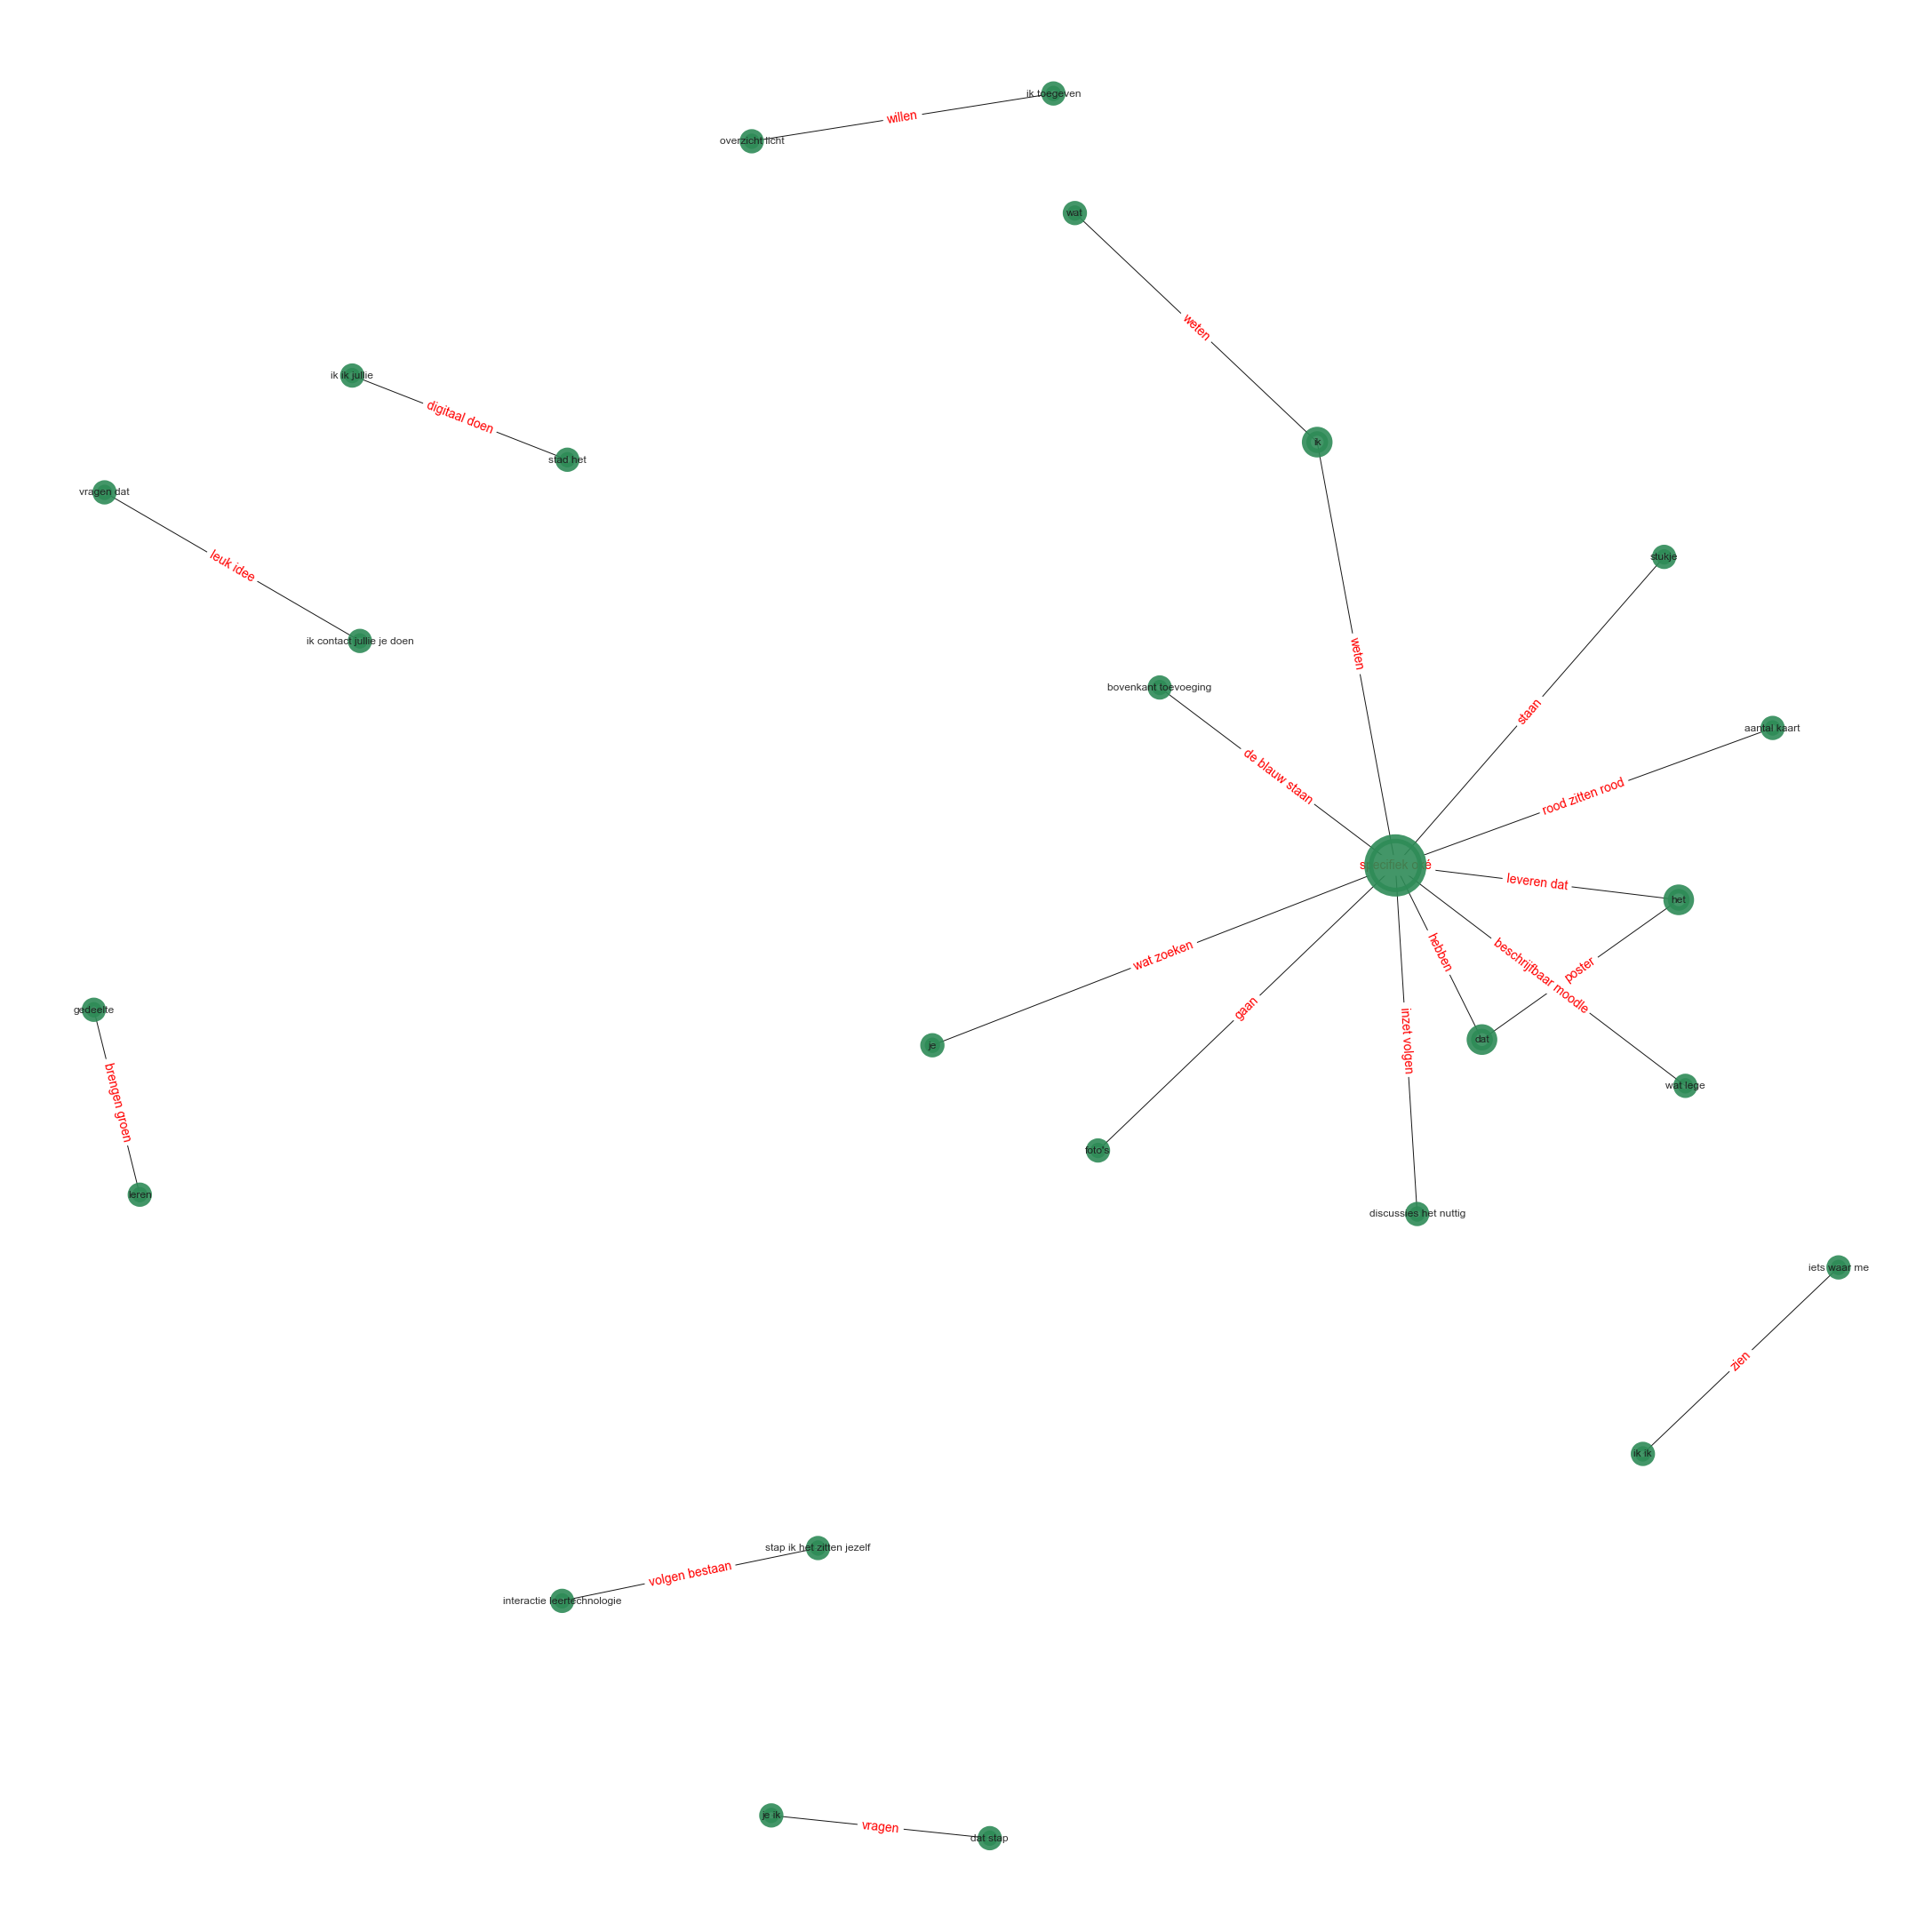

In [14]:
#https://github.com/explosion/spaCy/issues/4577 #Solve the spacy model download error
#https://github.com/bdmarius/python-knowledge-graph #Make a knowledge graph in English

import spacy
from spacy.lang.nl import Dutch
import networkx as nx
import matplotlib.pyplot as plt
#pip3 install https://github.com/explosion/spacy-models/releases/download/nl_core_news_sm-2.3.0/nl_core_news_sm-2.3.0.tar.gz
#https://heartbeat.fritz.ai/nlp-chronicles-intro-to-spacy-34949f1bc118#2930
def getSentences(text):
    nlp = spacy.load('nl_core_news_sm')
    #nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]

def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        #G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[2], title=triple[1])
        #G.add_edge(triple[1], triple[2])
# https://stackoverflow.com/questions/60919360/make-networkx-plot-look-nice
#https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/
#https://stackoverflow.com/questions/47094949/labeling-edges-in-networkx
#https://networkx.org/documentation/stable//reference/generated/networkx.drawing.nx_pylab.draw_networkx_labels.html
    edge_labels = nx.get_edge_attributes(G, 'title')
    pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order())) #nx.circular_layout(G) #nx.spring_layout(G)
    plt.figure(3,figsize=(30,30))
    d = dict(G.degree)
    nx.draw(G, pos, edge_color='black', width=1, linewidths=10, nodelist=d,
            node_size=[d[k]*300 for k in d], node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()},font_size=12)
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,font_color='red',font_size=14)
    plt.axis('off')
    plt.show()
    
#print(train_data['text'].tolist())
train_data_knowledge_processed = ""
#select a subset of datframe for certain group member(s)
#https://thispointer.com/python-pandas-select-rows-in-dataframe-by-conditions-on-multiple-columns/
subset_train_data = train_data[train_data['author'].isin(['1'])] #Select 1 or more group members #[train_data['author'] == '1']
train_data_knowledge = [i.strip() + ". " for i in subset_train_data['text'].tolist()]
i = 0
#print(train_data_knowledge[0])
for j in train_data_knowledge:
    train_data_knowledge_processed += train_data_knowledge[i]
    i = i+1
#print(train_data_knowledge_processed)

if __name__ == "__main__":

    text = train_data_knowledge_processed
    
    sentences = getSentences(text)
    nlp_model = spacy.load('nl_core_news_sm')

    triples = []
    print (text)
    for sentence in sentences:
        triples.append(processSentence(sentence))

    printGraph(triples)

## Interactive Network Graph with networkx and pyvis <a class="anchor" id="C3_13"></a>

In [36]:
# https://stackoverflow.com/questions/63492418/plotting-a-graph-with-neworkx-using-a-csv-file-as-co-occurence-matrix
# https://pyvis.readthedocs.io/en/latest/tutorial.html
#https://pyvis.readthedocs.io/en/latest/documentation.html
#https://visjs.github.io/vis-network/docs/network/nodes.html
#https://pyvis.readthedocs.io/en/latest/tutorial.html#adding-list-of-nodes-with-properties

from pyvis.network import Network
#net = Network()

# creating a dummy adjacency matrix of shape 20x20 with random values of 0 to 3

#adj_mat = np.random.randint(0, 3, size=(20, 20))
#np.fill_diagonal(adj_mat, 0)  # setting the diagonal values as 0
df = df_coccur #pd.DataFrame(adj_mat)

# create a graph from dataframe
G = nx.from_pandas_adjacency(df)
d = nx.degree(G)
degree_values = [v for k, v in d]

# visualize it with pyvis
N = Network(height='100%', width='100%', bgcolor='#222222', font_color='white')
N.barnes_hut()
i=0
for n in G.nodes:
    N.add_node(n, value = degree_values[i]*degree_values[i]*1000, title=n)
    i=i+1
for e in G.edges:
    N.add_edge(e[0], e[1])
    
neighbor_map = N.get_adj_list() #Create the neighbour map of each node

#Create the title for the node neighbours to display on hover
for node in N.nodes:
    node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])


N.show_buttons()
N.show("TestHover.html")

#N.write_html('./test1.html')

## Interactive Network Graph (SUBGRAPH IN A GRAPH) for showing multiple roles in one graph <a class="anchor" id="C3_14"></a>

In [20]:
# https://stackoverflow.com/questions/63492418/plotting-a-graph-with-neworkx-using-a-csv-file-as-co-occurence-matrix
# https://pyvis.readthedocs.io/en/latest/tutorial.html
#https://pyvis.readthedocs.io/en/latest/documentation.html
#https://visjs.github.io/vis-network/docs/network/nodes.html
#https://pyvis.readthedocs.io/en/latest/tutorial.html#adding-list-of-nodes-with-properties
#https://stackoverflow.com/questions/63717126/how-to-change-the-color-of-subgraph-using-pyvis

from pyvis.network import Network
#net = Network()

# creating a dummy adjacency matrix of shape 20x20 with random values of 0 to 3

#adj_mat = np.random.randint(0, 3, size=(20, 20))
#np.fill_diagonal(adj_mat, 0)  # setting the diagonal values as 0
df = df_coccur #pd.DataFrame(adj_mat)
df_SG = df_coccur_SG

# create a graph from dataframe
G = nx.from_pandas_adjacency(df)
SG = nx.from_pandas_adjacency(df_SG)
d = nx.degree(G)
degree_values = [v for k, v in d]

# visualize it with pyvis
N = Network(height='100%', width='100%', bgcolor='#222222', font_color='white')
N.force_atlas_2based()
i=0
for n in G.nodes:
    if n in SG.nodes:  # if the node is part of the sub-graph
        color = 'green'
    else:
        color = 'white'
    N.add_node(n, value = degree_values[i]*degree_values[i]*1000 , color=color)
    i=i+1
for e in G.edges:
    if e in SG.edges:  # if the edge is part of the sub-graph
        color = 'green'
    else:
        color = 'white'
    N.add_edge(e[0], e[1] , color=color)#, value = 0.2*G.number_of_edges(e[0],e[1]))

N.set_options = ('''
var options = {
  "nodes": {
    "borderWidth": 6,
    "borderWidthSelected": 6,
    "color": {
      "highlight": {
        "background": "rgba(255,127,27,1)"
      },
      "hover": {
        "background": "rgba(255,31,56,1)"
      }
    }
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "smooth": false
  },
  "interaction": {
    "hover": true
  },
  "physics": {
    "enabled": false,
    "minVelocity": 0.75
  }
}
''')
#N.show_buttons()
N.show("TELILARedTotalFinal.html")

#N.write_html('./test1.html')

In [33]:
# https://stackoverflow.com/questions/63492418/plotting-a-graph-with-neworkx-using-a-csv-file-as-co-occurence-matrix
# https://pyvis.readthedocs.io/en/latest/tutorial.html
#https://pyvis.readthedocs.io/en/latest/documentation.html
#https://visjs.github.io/vis-network/docs/network/nodes.html
#https://pyvis.readthedocs.io/en/latest/tutorial.html#adding-list-of-nodes-with-properties
#https://stackoverflow.com/questions/63717126/how-to-change-the-color-of-subgraph-using-pyvis
#https://github.com/WestHealth/pyvis/issues/48

from pyvis.network import Network
#net = Network()

# creating a dummy adjacency matrix of shape 20x20 with random values of 0 to 3

#adj_mat = np.random.randint(0, 3, size=(20, 20))
#np.fill_diagonal(adj_mat, 0)  # setting the diagonal values as 0
df = df_coccur #pd.DataFrame(adj_mat)
df_SG = df_coccur_SG

# create a graph from dataframe
G = nx.from_pandas_adjacency(df)
SG = nx.from_pandas_adjacency(df_SG)

# Find the degree of the graph
d = nx.degree(G)
degree_values = [v for k, v in d]

# visualize it with pyvis
N = Network(height='100%', width='100%', bgcolor='#222222', font_color='white')
#random_tree = nx.random_tree(50)
#https://networkx.org/documentation/stable/reference/drawing.html#module-networkx.drawing.layout

#layout = nx.kamada_kawai_layout(G)
layout = nx.spring_layout(G, scale=30, k=3/np.sqrt(G.order()))
#layout = nx.spectral_layout(G)
#N.from_nx(G)
#N.force_atlas_2based() #For the pyvis layout which works with toggle physics true
i=0
for n in G.nodes:
    if n in SG.nodes:  # if the node is part of the sub-graph
        #color = 'green'
        group=1
        shape = 'triangle'
    else:
        #color = 'yellow'
        group=2
        shape = 'dot'
    N.add_node(n, value = degree_values[i]*degree_values[i]*1000, group=group, shape=shape, title=n, x=layout[n][0]*50, y=layout[n][1]*50)
    i=i+1
for e in G.edges:
    if e in SG.edges:  # if the edge is part of the sub-graph
        #color = 'green'
        group=1
    else:
        #color = 'yellow'
        group=2
    N.add_edge(e[0], e[1] , group=group, width = 2*G.get_edge_data(e[0],e[1])['weight'], title=G.get_edge_data(e[0],e[1])['weight'])

neighbor_map = N.get_adj_list() #Create the neighbour map of each node

#Create the title for the node neighbours to display on hover
for node in N.nodes:
    node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])

N.toggle_physics(False)

N.show_buttons()
N.show("RedTotal_TELILAFinal.html")

#N.write_html('./test1.html')

## Plot the network graph with different centrality measures <a class="anchor" id="C3_15"></a>

In [37]:
# https://stackoverflow.com/questions/63492418/plotting-a-graph-with-neworkx-using-a-csv-file-as-co-occurence-matrix
# https://pyvis.readthedocs.io/en/latest/tutorial.html
#https://pyvis.readthedocs.io/en/latest/documentation.html
#https://visjs.github.io/vis-network/docs/network/nodes.html
#https://pyvis.readthedocs.io/en/latest/tutorial.html#adding-list-of-nodes-with-properties
#https://stackoverflow.com/questions/63717126/how-to-change-the-color-of-subgraph-using-pyvis
#https://github.com/WestHealth/pyvis/issues/48

## https://www.datacamp.com/community/tutorials/social-network-analysis-python
## https://www.pingshiuanchua.com/blog/post/using-graph-theory-for-keyword-ideas-expansion-via-networkx

from pyvis.network import Network
#net = Network()

# creating a dummy adjacency matrix of shape 20x20 with random values of 0 to 3

#adj_mat = np.random.randint(0, 3, size=(20, 20))
#np.fill_diagonal(adj_mat, 0)  # setting the diagonal values as 0
df = df_coccur #pd.DataFrame(adj_mat)
df_SG = df_coccur_SG

# create a graph from dataframe
G = nx.from_pandas_adjacency(df)
SG = nx.from_pandas_adjacency(df_SG)

#Find the degree of the graph
d = nx.degree(G)
degree_values = [v for k, v in d]

#Find the betweenness centrality
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
betCent_values = [v for v in betCent.values()]

#Find the eigenvector centrality
eigenCent = nx.eigenvector_centrality(G)
eigenCent_values = [v for v in eigenCent.values()]

# visualize it with pyvis
N = Network(height='100%', width='100%', bgcolor='#222222', font_color='white')
#random_tree = nx.random_tree(50)
#https://networkx.org/documentation/stable/reference/drawing.html#module-networkx.drawing.layout

#layout = nx.kamada_kawai_layout(G)
layout = nx.spring_layout(G, scale=30, k=3/np.sqrt(G.order()))
#layout = nx.spectral_layout(G)
#N.from_nx(G)
#N.force_atlas_2based() #For the pyvis layout which works with toggle physics true
i=0
for n in G.nodes:
    if n in SG.nodes:  # if the node is part of the sub-graph
        #color = 'green'
        group=1
        shape = 'triangle'
    else:
        #color = 'yellow'
        group=2
        shape = 'dot'
    N.add_node(n, value = eigenCent_values[i]*eigenCent_values[i]*1000, group=group, shape=shape, title=n, x=layout[n][0]*50, y=layout[n][1]*50)
    i=i+1
for e in G.edges:
    if e in SG.edges:  # if the edge is part of the sub-graph
        #color = 'green'
        group=1
    else:
        #color = 'yellow'
        group=2
    N.add_edge(e[0], e[1] , group=group, width = 2*G.get_edge_data(e[0],e[1])['weight'], title=G.get_edge_data(e[0],e[1])['weight'])

neighbor_map = N.get_adj_list() #Create the neighbour map of each node

#Create the title for the node neighbours to display on hover
for node in N.nodes:
    node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])

N.toggle_physics(False)

N.show_buttons()
N.show("RedTotal_TELILAFinaleigencentrality.html")

#N.write_html('./test1.html')

In [ ]:
## Betweenness and Eigen Centrality for the Subgraph

betCent = nx.betweenness_centrality(SG, normalized=True, endpoints=True)
betCent_values = [v for v in betCent.values()]
sorted(betCent, key=betCent.get, reverse=True)[:10]
eigenCent = nx.eigenvector_centrality(SG)
eigenCent_values = [v for v in eigenCent.values()]
sorted(eigenCent, key=eigenCent.get, reverse=True)[:10]

In [42]:
sorted(betCent, key=betCent.get, reverse=True)[:10]

['goed',
 'team',
 'gebruik',
 'technologie',
 'rol',
 'mak',
 'idee',
 'voorbeeld',
 'allerlei',
 'inzet']

In [43]:
sorted(eigenCent, key=eigenCent.get, reverse=True)[:10]

['mak',
 'poster',
 'goed',
 'rol',
 'allerlei',
 'zak',
 'deelonderwerp',
 'denkt',
 'mindmap',
 'mis']